<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230709_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [5]:
main_figsize=(15,3)

In [6]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [7]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self, input_dim=5):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [8]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    #test_analysis['TrainSum(DR)']= []
    #test_analysis['TrainStd(DR)']= []
    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []


    if model2_ == None:
        ax = XS_test[:,0:b_dim]
        ref_ax = XS_train[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)

    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    test_analysis['Test Std(MI)'].append(np.std(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    test_analysis['TrainStd(MI)'].append(np.std(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))

    print("Test f1 score: {}".format(f1))

    test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1,test_analysis_df

In [9]:

def test_all_data(generator,adapter,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if adapter == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = adapter(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = generator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({train_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [10]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        return torch.cat(h, dim=1)

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret
        return loss

In [11]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    generator = Generator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Sensitivity_Adapter(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)
    loss_mse = customLoss(mine)

    kld_loss = nn.KLDivLoss(reduction='batchmean')

    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        '''
        if do_mine and lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------
            # MI(x_t,y_t) < MI (x_t+1,y_t+1) 이되도록 학습한다.
            s = np.random.choice(range(500,train_len-500))
            mine_loss = loss_mse(xs[s-500:s],y_train[s-500:s]) - loss_mse(xs[s:s+500],y_train[s:s+500])
            #print(mine_loss.mean())
        else:
            mine_loss = torch.tensor(0.0)
        '''
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,test_analysis = test_model(generator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,test_analysis,generator,adapter,df_loss

In [12]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [13]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [14]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

In [15]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({train_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [16]:
def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0):

    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
    lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    #lambda_f_set = [-0.1,0.0,0.5,0.9] #[-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]

    infos = {}
    for lambda_f in lambda_f_set:
        print(f'######################### Lambda {lambda_f} ###########################')
        f1,test_analysis,last_generator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        for clm in test_analysis.columns:
            if clm not in result_table2:
                result_table2[clm] = []
            result_table2[clm].append(test_analysis[clm].values[0])


    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    a_columns = []
    XS = X_train['b'].values
    for bk in np.unique(XS,axis = 0):
        a_columns.append(f'Sum(MI{bk}.0)')
    a_columns.append('Test Sum(MI)')
    a_columns.append('TrainSum(MI)')

    print(a_columns)
    stds = np.std(result4_df[1:][a_columns],axis=1)
    print(stds)
    best_lambda = np.argmax(stds) #result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
    print('best_lambda=',best_lambda)
    result_df[['Normal model',f'λ_0.{best_lambda}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    best_lambda = np.argmin(stds) #result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
    print('best_lambda=',best_lambda)
    result_df[['Normal model',f'λ_0.{best_lambda}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return result4_df

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [49]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [50]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [51]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


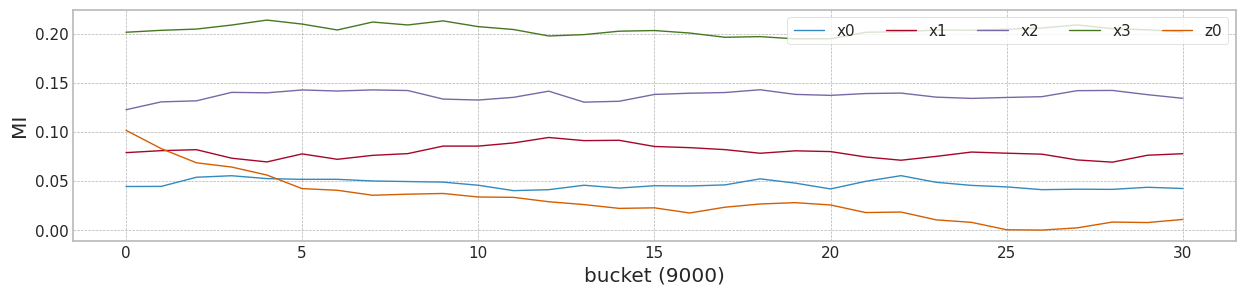

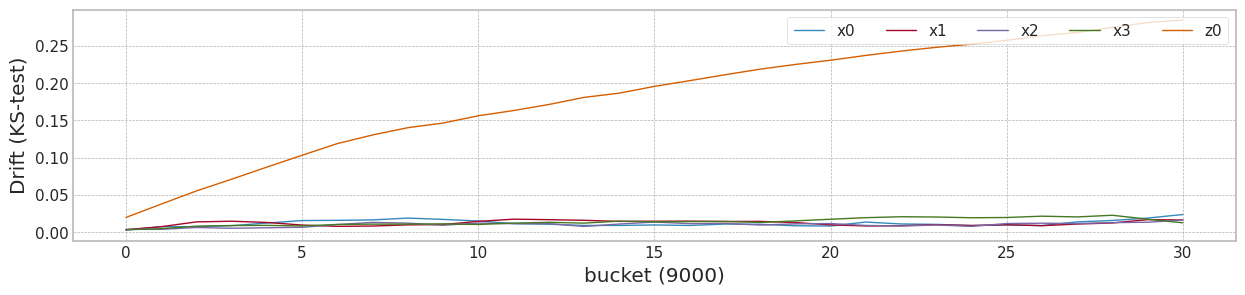

MI Analysis MI Max 0.20162, Min 0.04443, Mean 0.10986, Std 0.05270
cpu


100%|██████████| 1000/1000 [01:58<00:00,  8.47it/s]


MSE: 0.29
RMSE: 0.54


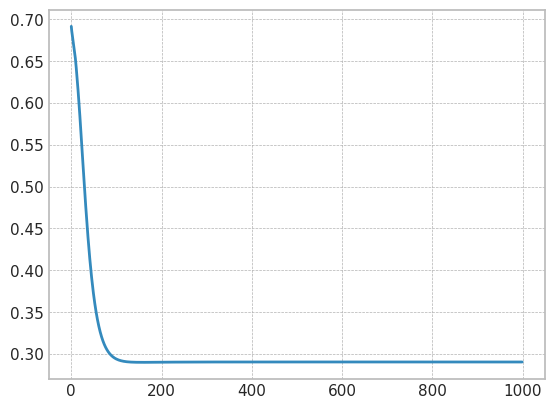

F1 Score:0.87616
Dataset structure X_train, torch.Size([9000, 5]) X_test, torch.Size([9000, 5]) X_live (39000, 5)
Truncate 36000 rows from live_set (39000, 5)


100%|██████████| 31/31 [00:00<00:00, 147.94it/s]


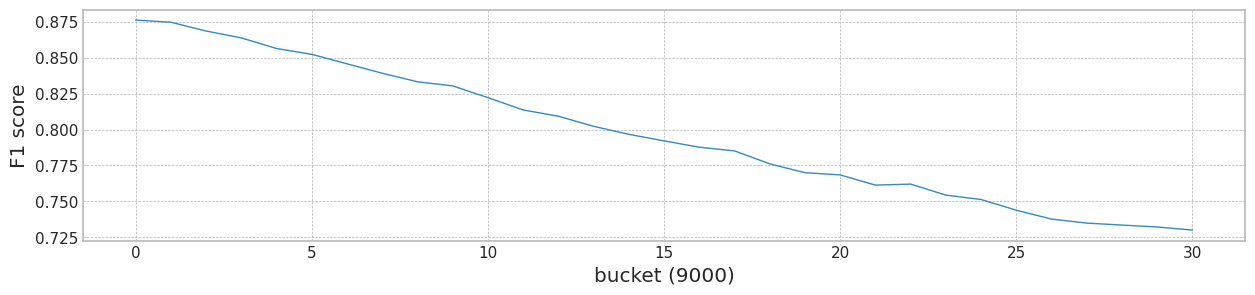

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.730016  0.876157  0.796927  0.730016  0.549316


In [52]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
loss_mse = customLoss(mine)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.mean().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())


plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

cpu


100%|██████████| 300/300 [00:23<00:00, 13.04it/s]


<Axes: >

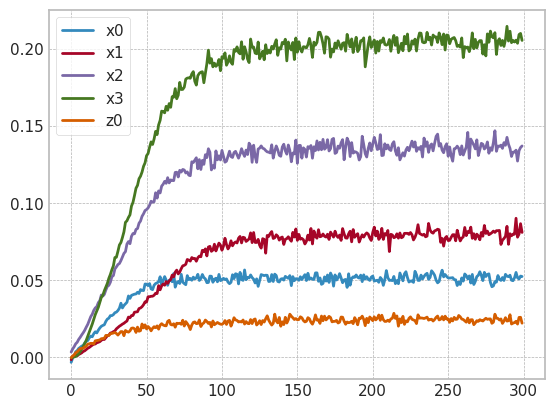

In [54]:
df_loss.plot()

In [55]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.421766   0
1      0.447230  0.556479  0.629077  0.735705  0.529014   0
2      0.489501  0.704159  0.760582  0.582973  0.570549   0
3      0.581446  0.301839  0.443337  0.515173  0.396001   0
4      0.571642  0.639275  0.524701  0.583380  0.561748   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.185740  39
39996  0.426322  0.302644  0.484909  0.587518  0.721101  39
39997  0.374186  0.587769  0.624447  0.598315  0.489479  39
39998  0.470439  0.265430  0.218971  0.645349  1.258888  39
39999  0.654583  0.419378  0.800216  0.614031  1.055564  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cpu


100%|██████████| 4000/4000 [00:14<00:00, 269.25it/s]


Test f1 score: 0.8763676148796499
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7999359745907817
######################### Lambda 0.0 ###########################
cpu


100%|██████████| 4000/4000 [01:13<00:00, 54.59it/s]


Test f1 score: 0.8797000771860183
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.21it/s]


mean of drift:
x0    1.000000
x1    0.778541
x2    0.854201
x3    1.000000
z0    0.981136
dtype: float64
Mean F1 for all data: 0.8365654593518931
######################### Lambda 0.1 ###########################
cpu


100%|██████████| 4000/4000 [01:14<00:00, 54.02it/s]


Test f1 score: 0.8806003089825646
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]


mean of drift:
x0    0.247441
x1    0.313416
x2    0.174885
x3    0.274577
z0    0.395573
dtype: float64
Mean F1 for all data: 0.7375280900412973
######################### Lambda 0.2 ###########################
cpu


100%|██████████| 4000/4000 [01:13<00:00, 54.44it/s]


Test f1 score: 0.8775757575757576
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


mean of drift:
x0    0.297498
x1    0.251853
x2    0.178233
x3    0.226301
z0    0.185204
dtype: float64
Mean F1 for all data: 0.8243569917715353
######################### Lambda 0.3 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.65it/s]


Test f1 score: 0.8810020876826723
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.262738
x1    0.180323
x2    0.158996
x3    0.183892
z0    0.244036
dtype: float64
Mean F1 for all data: 0.8475814202708544
######################### Lambda 0.4 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.16it/s]


Test f1 score: 0.8802283455922714
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


mean of drift:
x0    0.207366
x1    0.166358
x2    0.119964
x3    0.147061
z0    0.192262
dtype: float64
Mean F1 for all data: 0.8470044144704876
######################### Lambda 0.5 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.28it/s]


Test f1 score: 0.8798334976448681
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.47it/s]


mean of drift:
x0    0.154108
x1    0.122552
x2    0.105104
x3    0.124699
z0    0.169767
dtype: float64
Mean F1 for all data: 0.8422963665402704
######################### Lambda 0.6 ###########################
cpu


100%|██████████| 4000/4000 [01:10<00:00, 57.01it/s]


Test f1 score: 0.8797808219178082
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.63it/s]


mean of drift:
x0    0.096867
x1    0.087695
x2    0.081151
x3    0.103903
z0    0.155728
dtype: float64
Mean F1 for all data: 0.8402442682297094
######################### Lambda 0.7 ###########################
cpu


100%|██████████| 4000/4000 [01:08<00:00, 58.48it/s]


Test f1 score: 0.8797808219178082
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.98it/s]


mean of drift:
x0    0.056129
x1    0.072326
x2    0.067771
x3    0.089305
z0    0.110914
dtype: float64
Mean F1 for all data: 0.8336418384359247
######################### Lambda 0.8 ###########################
cpu


100%|██████████| 4000/4000 [01:08<00:00, 58.31it/s]


Test f1 score: 0.8793518721261221
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.11it/s]


mean of drift:
x0    0.039330
x1    0.039591
x2    0.041287
x3    0.072452
z0    0.133133
dtype: float64
Mean F1 for all data: 0.8267047800130374
######################### Lambda 0.9 ###########################
cpu


100%|██████████| 4000/4000 [01:08<00:00, 58.36it/s]


Test f1 score: 0.8787315472936031
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.17it/s]


mean of drift:
x0    0.027670
x1    0.021219
x2    0.025355
x3    0.040487
z0    0.163351
dtype: float64
Mean F1 for all data: 0.8148511974860639


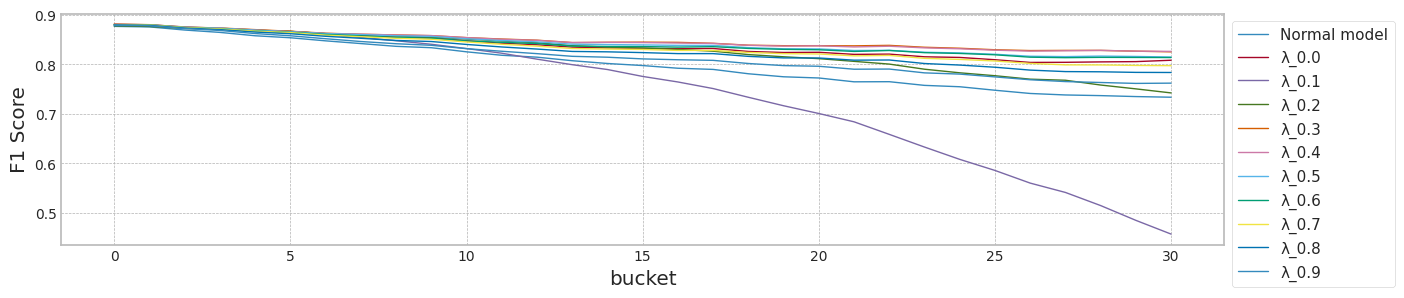

max_mean_lambda= 0.3


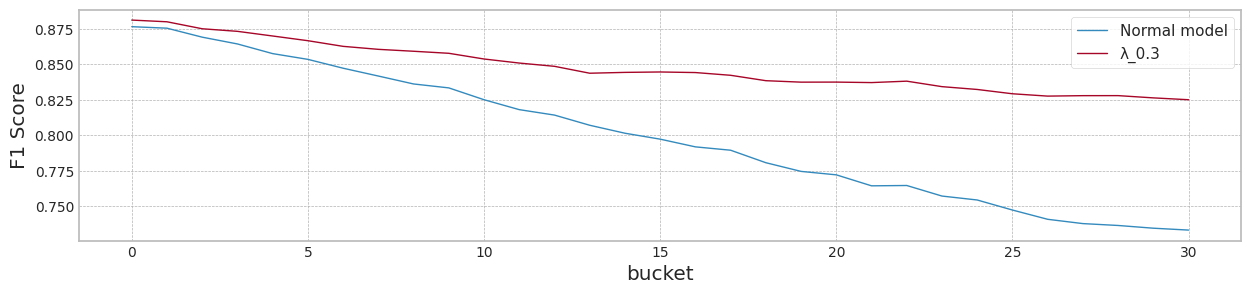

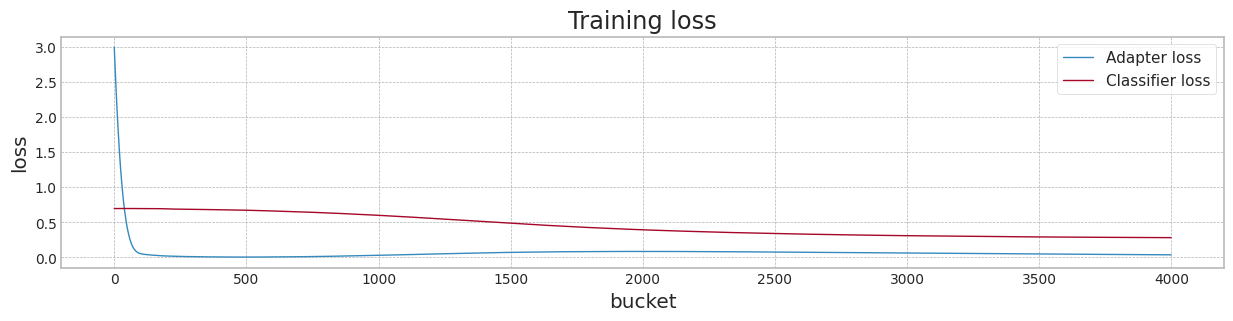

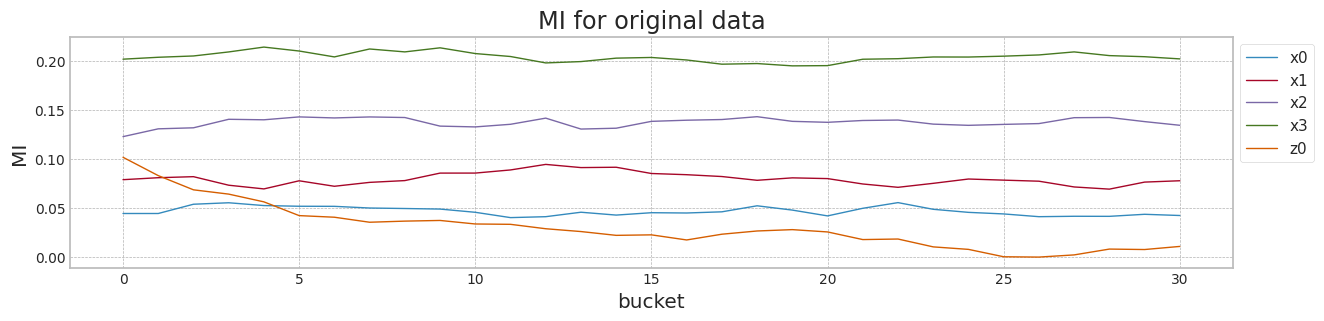

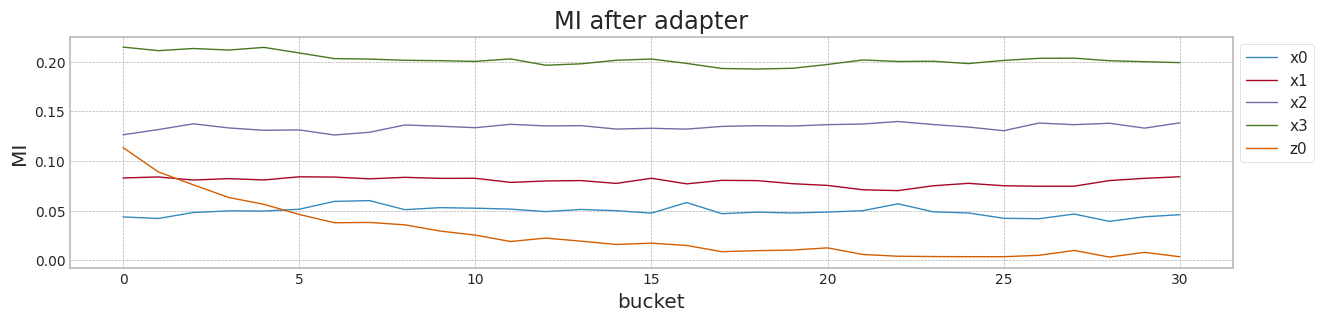

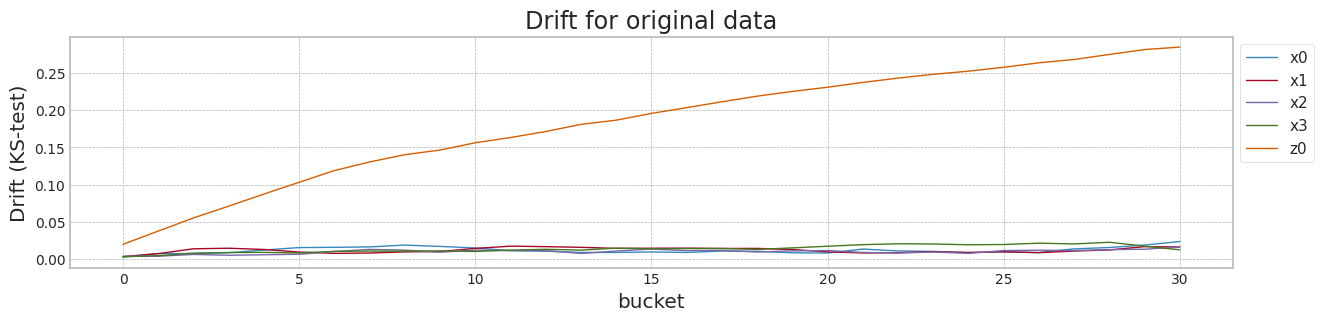

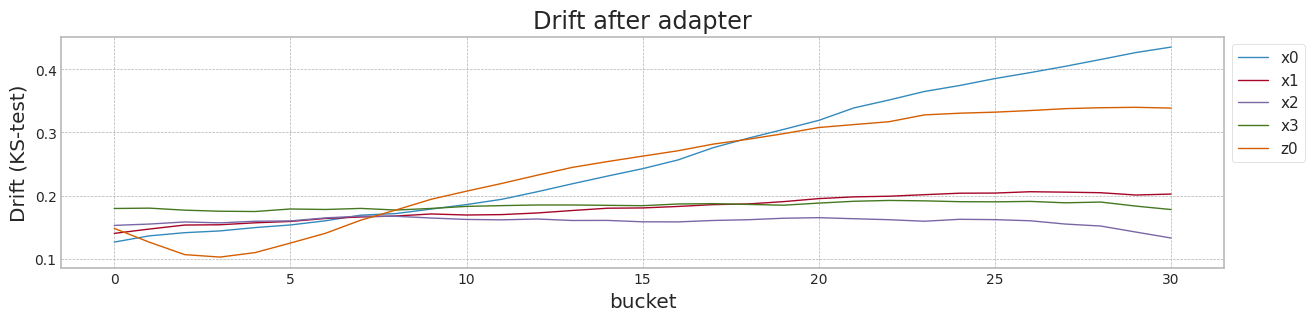

['Sum(MI0.0)', 'Sum(MI1.0)', 'Sum(MI2.0)', 'Sum(MI3.0)', 'Sum(MI4.0)', 'Sum(MI5.0)', 'Sum(MI6.0)', 'Sum(MI7.0)', 'Sum(MI8.0)', 'Test Sum(MI)', 'TrainSum(MI)']
1     0.063036
2     0.058985
3     0.057804
4     0.058502
5     0.058108
6     0.057792
7     0.057978
8     0.057467
9     0.057726
10    0.058333
dtype: float64
best_lambda= 0


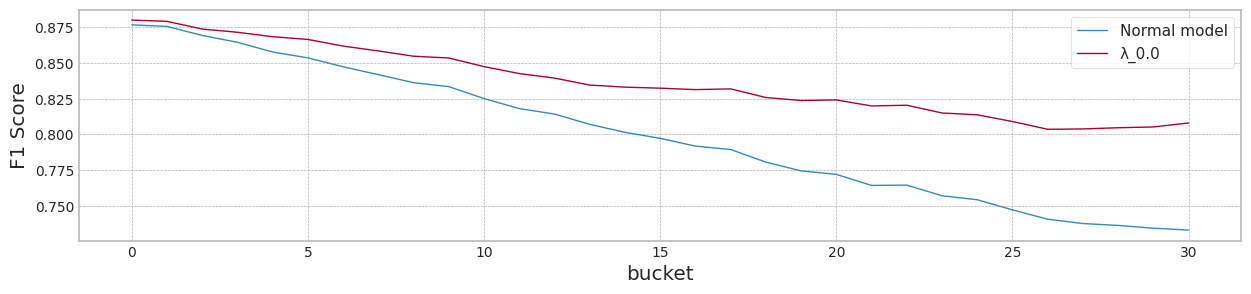

best_lambda= 7


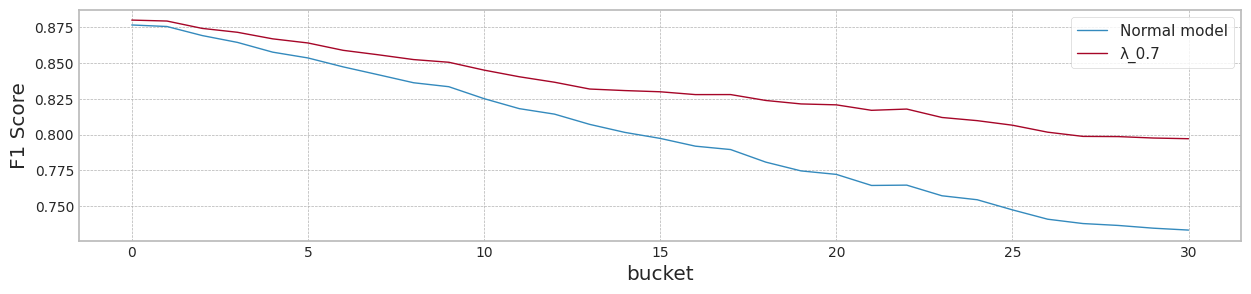

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.876368  0.876368  0.799936  0.733370    0.747456   
1                     0.0  0.879700  0.879700  0.836565  0.808013    0.747563   
2                     0.1  0.880600  0.880600  0.737528  0.457114    0.744455   
3                     0.2  0.877576  0.877576  0.824357  0.742065    0.744786   
4                     0.3  0.881002  0.881002  0.847581  0.825009    0.748117   
5                     0.4  0.880228  0.880228  0.847004  0.825866    0.747908   
6                     0.5  0.879833  0.879833  0.842296  0.814528    0.748340   
7                     0.6  0.879781  0.879781  0.840244  0.813458    0.747495   
8                     0.7  0.879781  0.879781  0.833642  0.797062    0.745093   
9                     0.8  0.879352  0.879352  0.826705  0.783290    0.745706   
10                    0.9  0.878732  0.878732  0.814851  0.761789    0.746693   

    Std(MI0.0)  Sum(DR0.0)  Std(DR0.0)  Sum(MI1.0)  ...  Sum(MI8.0)  \
0     0.093809    0.181000    0.028441    0.626555  ...    0.548409   
1     0.093590    4.990000    0.004000    0.626816  ...    0.548719   
2     0.094790    1.122000    0.051797    0.629172  ...    0.534605   
3     0.094285    1.037778    0.055495    0.625354  ...    0.545773   
4     0.093807    0.864889    0.043362    0.626751  ...    0.546026   
5     0.093781    0.729222    0.042218    0.626485  ...    0.546736   
6     0.093863    0.615778    0.038951    0.626667  ...    0.547060   
7     0.093693    0.506556    0.035853    0.625136  ...    0.547678   
8     0.093910    0.416000    0.024870    0.625944  ...    0.547694   
9     0.093801    0.304556    0.015400    0.626433  ...    0.547332   
10    0.093955    0.186778    0.008496    0.626517  ...    0.546514   

    Std(MI8.0)  Sum(DR8.0)  Std(DR8.0)  TrainSum(MI)  TrainStd(MI)  \
0     0.062633    0.173111    0.023705      0.584127      0.053828   
1     0.062620    4.959333    0.016267      0.560123      0.059427   
2     0.063631    0.910111    0.052920      0.611783      0.056688   
3     0.062757    0.831778    0.047931      0.631287      0.054400   
4     0.062745    0.750333    0.033941      0.612852      0.054885   
5     0.062628    0.605889    0.030914      0.635055      0.056614   
6     0.062610    0.555556    0.016033      0.616552      0.053019   
7     0.062625    0.447556    0.016381      0.637570      0.054996   
8     0.062440    0.333778    0.012763      0.610884      0.057463   
9     0.062688    0.254222    0.013062      0.603140      0.058721   
10    0.062865    0.194889    0.019301      0.597850      0.055243   

    Test Sum(MI)  Test Std(MI)  Test Sum(DR)  Test Std(DR)  
0       0.549369      0.052727      0.000000      0.000000  
1       0.528249      0.058112      4.977000      0.009145  
2       0.574706      0.054461      0.932222      0.028995  
3       0.608607      0.051965      0.863889      0.035532  
4       0.580477      0.056886      0.734111      0.018111  
5       0.607029      0.051131      0.598556      0.014584  
6       0.588954      0.052260      0.480111      0.014225  
7       0.604034      0.055147      0.376000      0.013580  
8       0.585907      0.056286      0.293333      0.010070  
9       0.583100      0.058868      0.204556      0.009098  
10      0.573638      0.051577      0.108111      0.003563  

[11 rows x 47 columns]

In [56]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

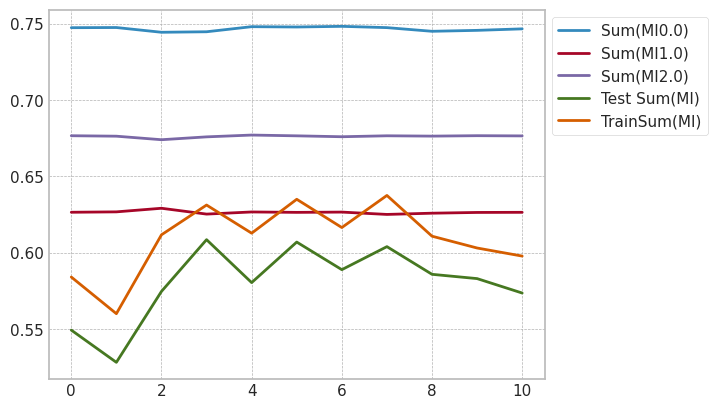

In [57]:
result_df[['Sum(MI0.0)','Sum(MI1.0)','Sum(MI2.0)','Test Sum(MI)','TrainSum(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

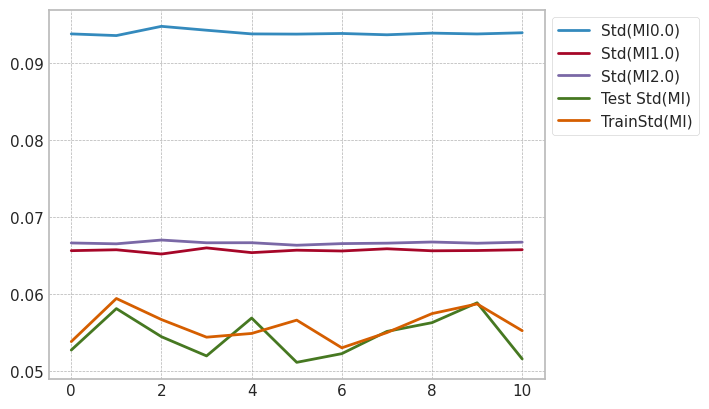

In [58]:
result_df[['Std(MI0.0)','Std(MI1.0)','Std(MI2.0)','Test Std(MI)','TrainStd(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

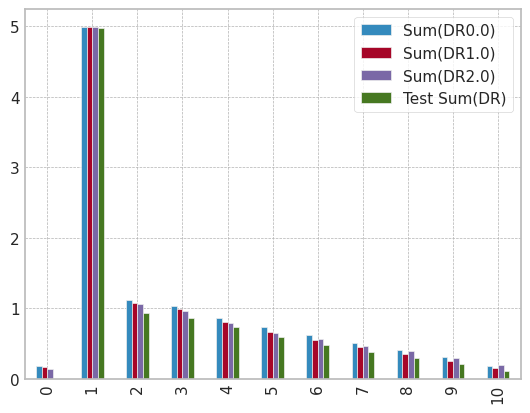

In [59]:
result_df[['Sum(DR0.0)','Sum(DR1.0)','Sum(DR2.0)','Test Sum(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

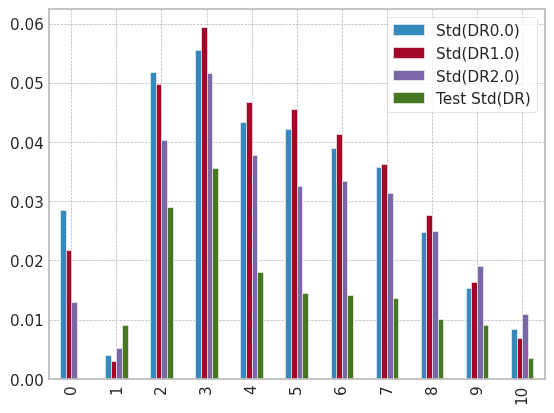

In [60]:
result_df[['Std(DR0.0)','Std(DR1.0)','Std(DR2.0)','Test Std(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [61]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [62]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [63]:
x1.shape

(40000, 5)

In [64]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [65]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:06<00:00,  4.67it/s]


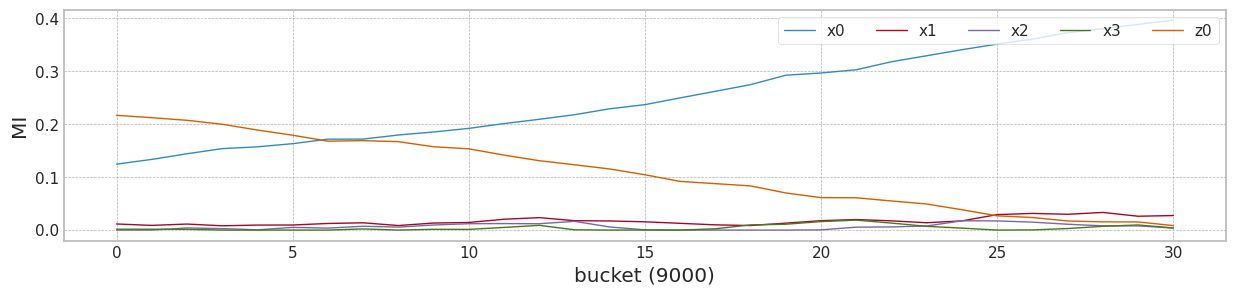

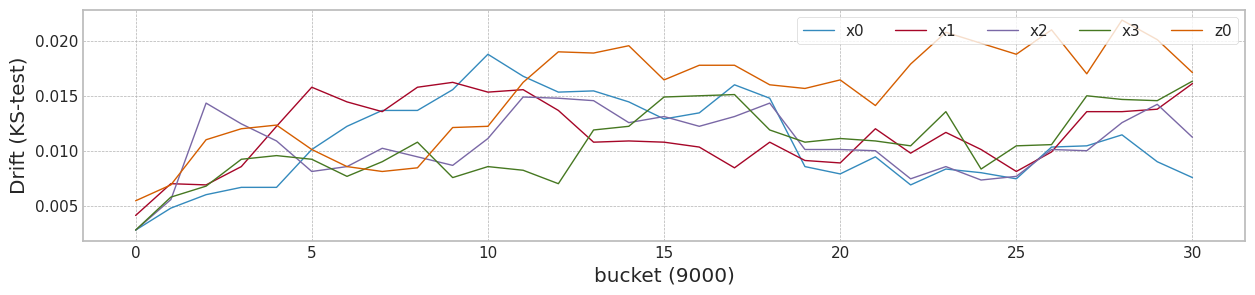

MI Analysis MI Max 0.21692, Min 0.00000, Mean 0.07095, Std 0.08666
cpu


100%|██████████| 1000/1000 [01:59<00:00,  8.36it/s]


MSE: 0.03
RMSE: 0.19


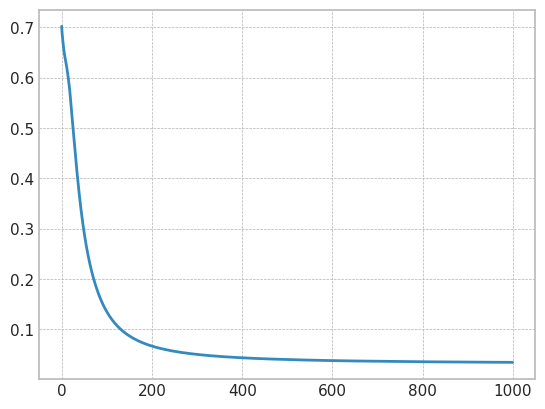

F1 Score:0.98767
Dataset structure X_train, torch.Size([9000, 5]) X_test, torch.Size([9000, 5]) X_live (39000, 5)
Truncate 36000 rows from live_set (39000, 5)


100%|██████████| 31/31 [00:00<00:00, 134.35it/s]


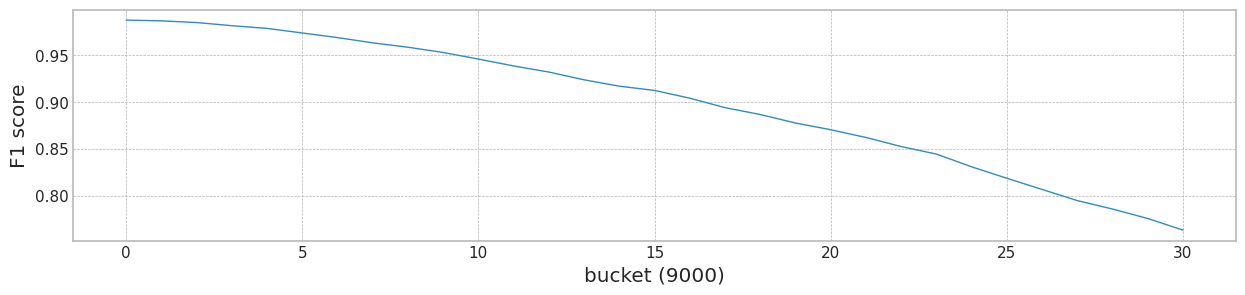

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.763475  0.987668  0.899322  0.763475  0.354735


In [66]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [67]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.366139   0
1      0.610533  0.420412  0.508390  0.580336  0.662926   0
2      0.556874  0.464734  0.669603  0.724770  0.486574   0
3      0.344341  0.646524  0.340976  0.528780  0.611850   0
4      0.503142  0.550860  0.598773  0.465698  0.487044   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.709407  39
39996  0.358451  0.483875  0.341855  0.574439  0.695384  39
39997  0.559469  0.343824  0.542547  0.575250  0.504288  39
39998  0.433692  0.530132  0.301231  0.282353  0.762158  39
39999  0.538629  0.637825  0.358726  0.768301  0.522435  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 261.33it/s]


Test f1 score: 0.9662005741272339
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.77it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8790432735532113
######################### Lambda 0.0 ###########################
cpu


100%|██████████| 4000/4000 [01:21<00:00, 49.29it/s]


Test f1 score: 0.9965792474344357
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.60it/s]


mean of drift:
x0    0.999323
x1    0.808663
x2    0.944226
x3    1.000000
z0    0.968237
dtype: float64
Mean F1 for all data: 0.9270669474261033
######################### Lambda 0.1 ###########################
cpu


100%|██████████| 4000/4000 [01:17<00:00, 51.76it/s]


Test f1 score: 0.9850746268656716
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.80it/s]


mean of drift:
x0    0.505211
x1    0.278394
x2    0.146172
x3    0.125900
z0    0.421115
dtype: float64
Mean F1 for all data: 0.8904599645970671
######################### Lambda 0.2 ###########################
cpu


100%|██████████| 4000/4000 [01:17<00:00, 51.76it/s]


Test f1 score: 0.9809900244682853
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.17it/s]


mean of drift:
x0    0.551319
x1    0.202796
x2    0.105018
x3    0.058685
z0    0.265125
dtype: float64
Mean F1 for all data: 0.8253517082055816
######################### Lambda 0.3 ###########################
cpu


100%|██████████| 4000/4000 [01:13<00:00, 54.67it/s]


Test f1 score: 0.9784348808739052
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.59it/s]


mean of drift:
x0    0.524907
x1    0.161226
x2    0.081272
x3    0.032136
z0    0.202749
dtype: float64
Mean F1 for all data: 0.816493239117033
######################### Lambda 0.4 ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 55.58it/s]


Test f1 score: 0.9754036800600826
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.424265
x1    0.130186
x2    0.063211
x3    0.016695
z0    0.157244
dtype: float64
Mean F1 for all data: 0.8923286975385671
######################### Lambda 0.5 ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 56.13it/s]


Test f1 score: 0.9731147540983606
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


mean of drift:
x0    0.384290
x1    0.099835
x2    0.043462
x3    0.011237
z0    0.137609
dtype: float64
Mean F1 for all data: 0.8970223225363386
######################### Lambda 0.6 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.83it/s]


Test f1 score: 0.9590643274853802
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.99it/s]


mean of drift:
x0    0.409566
x1    0.073993
x2    0.022348
x3    0.030154
z0    0.127452
dtype: float64
Mean F1 for all data: 0.8616469215085293
######################### Lambda 0.7 ###########################
cpu


100%|██████████| 4000/4000 [01:10<00:00, 56.44it/s]


Test f1 score: 0.9560876398261995
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.76it/s]


mean of drift:
x0    0.220577
x1    0.052387
x2    0.014821
x3    0.022111
z0    0.103932
dtype: float64
Mean F1 for all data: 0.8808475086355303
######################### Lambda 0.8 ###########################
cpu


100%|██████████| 4000/4000 [01:08<00:00, 58.41it/s]


Test f1 score: 0.9531436987940716
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.31it/s]


mean of drift:
x0    0.149842
x1    0.034312
x2    0.011731
x3    0.017434
z0    0.077606
dtype: float64
Mean F1 for all data: 0.8829306086726084
######################### Lambda 0.9 ###########################
cpu


100%|██████████| 4000/4000 [01:07<00:00, 59.07it/s]


Test f1 score: 0.9504442612439314
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.65it/s]


mean of drift:
x0    0.052624
x1    0.018186
x2    0.012573
x3    0.014419
z0    0.051201
dtype: float64
Mean F1 for all data: 0.8831012151235406


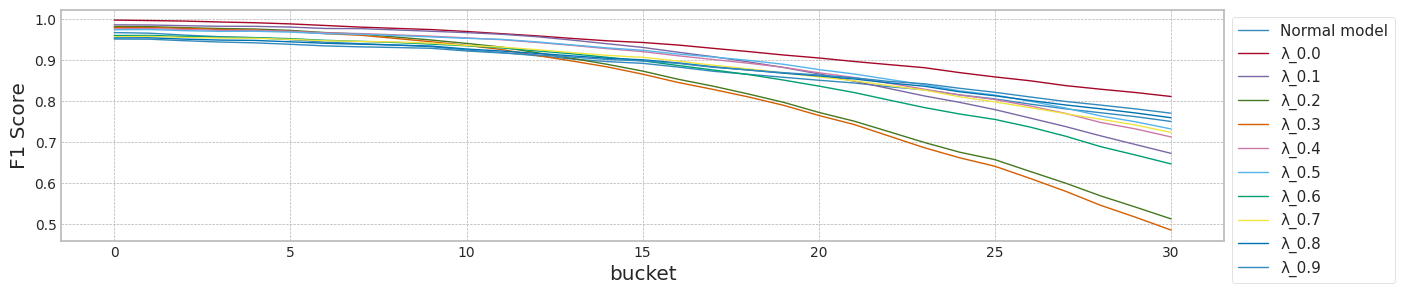

max_mean_lambda= 0.0


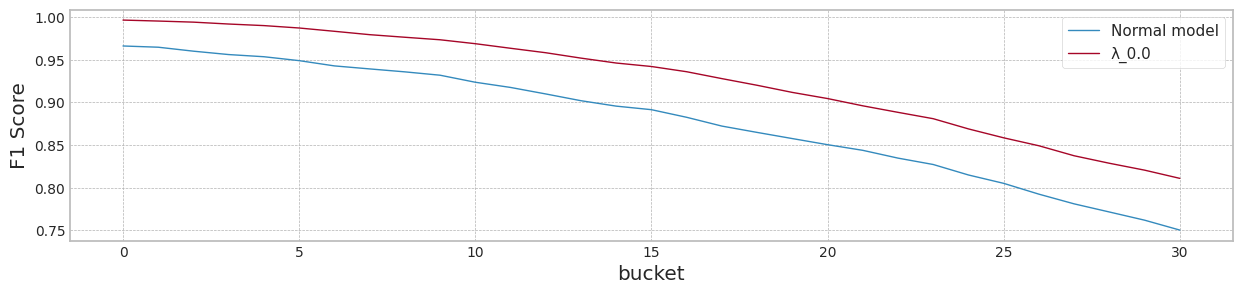

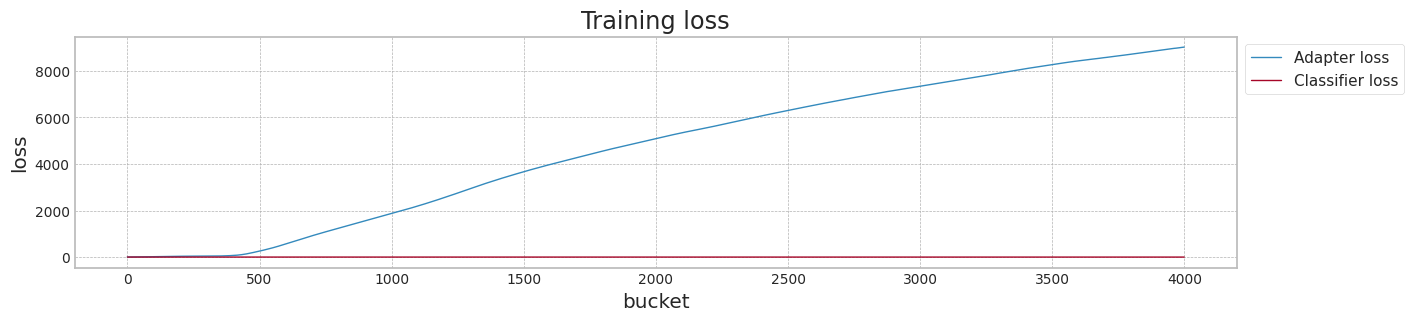

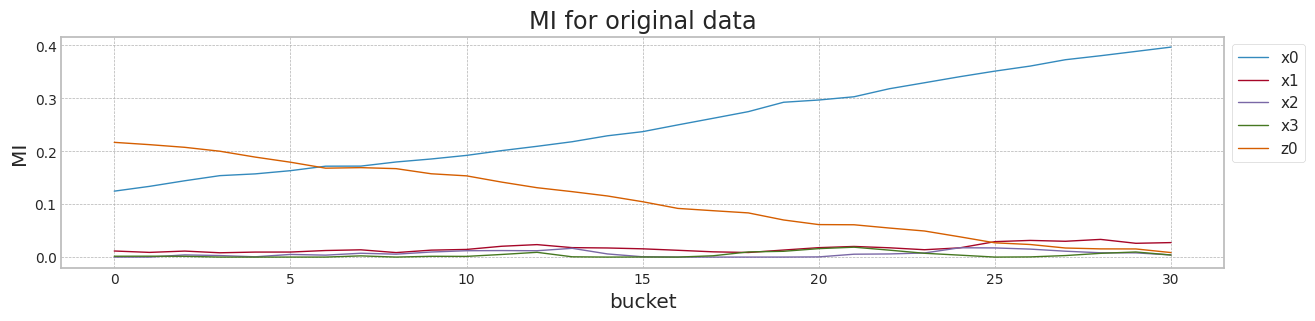

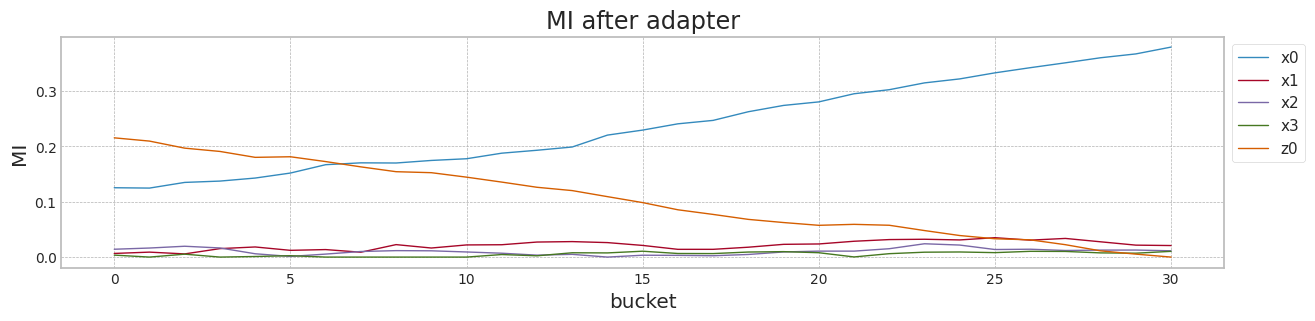

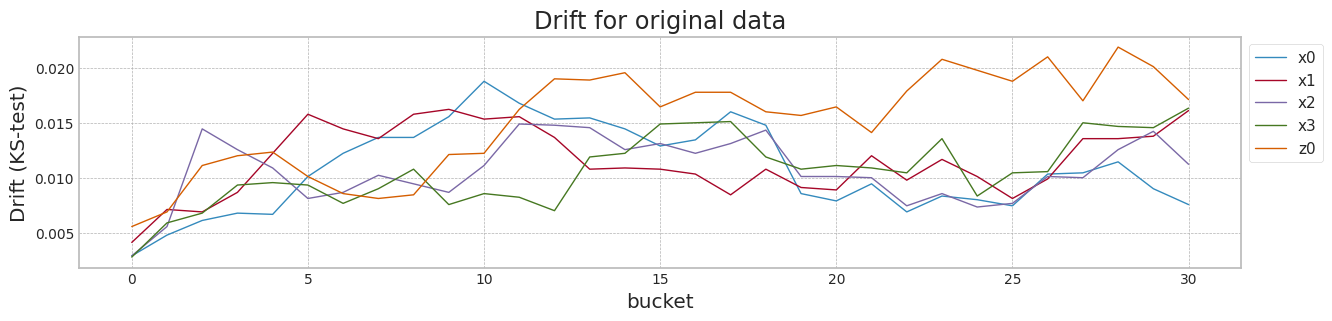

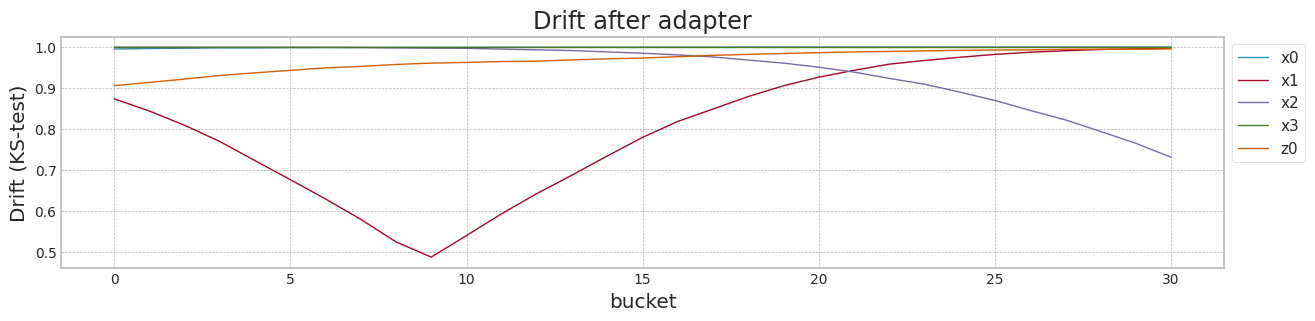

['Sum(MI0.0)', 'Sum(MI1.0)', 'Sum(MI2.0)', 'Sum(MI3.0)', 'Sum(MI4.0)', 'Sum(MI5.0)', 'Sum(MI6.0)', 'Sum(MI7.0)', 'Sum(MI8.0)', 'Test Sum(MI)', 'TrainSum(MI)']
1     0.027610
2     0.027217
3     0.026856
4     0.027944
5     0.027278
6     0.027712
7     0.028185
8     0.028515
9     0.027298
10    0.027813
dtype: float64
best_lambda= 7


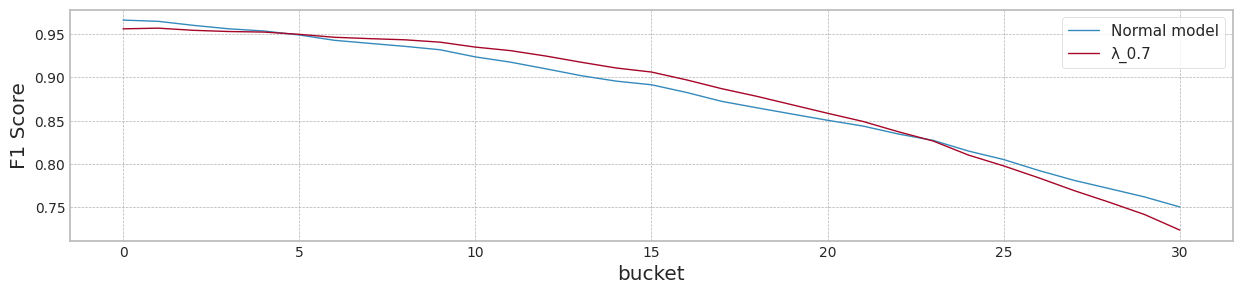

best_lambda= 2


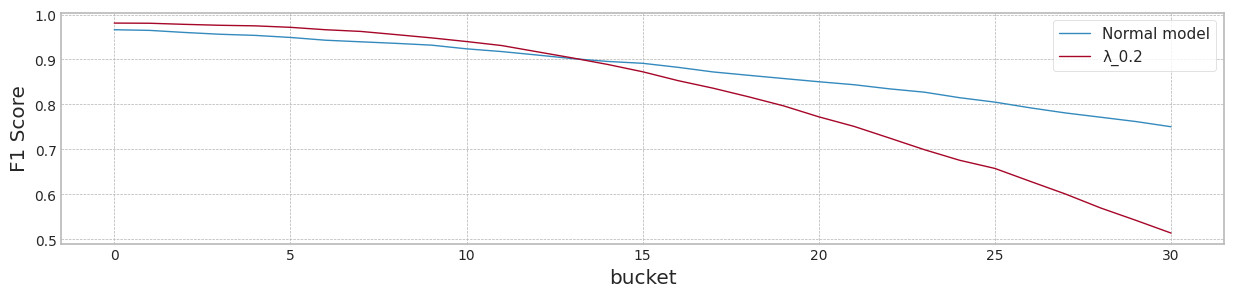

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.966201  0.966201  0.879043  0.750255    0.361798   
1                     0.0  0.996579  0.996579  0.927067  0.810918    0.362222   
2                     0.1  0.985075  0.985075  0.890460  0.672802    0.361643   
3                     0.2  0.980990  0.980990  0.825352  0.513611    0.361918   
4                     0.3  0.978435  0.978435  0.816493  0.486430    0.361644   
5                     0.4  0.975404  0.975404  0.892329  0.712710    0.361296   
6                     0.5  0.973115  0.973115  0.897022  0.732095    0.361258   
7                     0.6  0.959064  0.959064  0.861647  0.647113    0.360777   
8                     0.7  0.956088  0.956088  0.880848  0.723568    0.360584   
9                     0.8  0.953144  0.953144  0.882931  0.759366    0.361053   
10                    0.9  0.950444  0.950444  0.883101  0.770367    0.361022   

    Std(MI0.0)  Sum(DR0.0)  Std(DR0.0)  Sum(MI1.0)  ...  Sum(MI8.0)  \
0     0.102542    0.096111    0.005867    0.380247  ...    0.395410   
1     0.102503    4.853000    0.042561    0.380690  ...    0.394957   
2     0.102513    1.324444    0.101875    0.379996  ...    0.394662   
3     0.102471    0.974444    0.090783    0.381952  ...    0.395182   
4     0.102352    0.777556    0.084311    0.381110  ...    0.396210   
5     0.102268    0.628000    0.075913    0.380749  ...    0.394777   
6     0.102285    0.512333    0.065956    0.380583  ...    0.396081   
7     0.102330    0.442667    0.054551    0.380212  ...    0.396198   
8     0.102289    0.356667    0.047417    0.380251  ...    0.395783   
9     0.102360    0.278333    0.036318    0.380446  ...    0.396762   
10    0.102472    0.179889    0.018462    0.380075  ...    0.394631   

    Std(MI8.0)  Sum(DR8.0)  Std(DR8.0)  TrainSum(MI)  TrainStd(MI)  \
0     0.090607    0.105444    0.004840      0.356049      0.089014   
1     0.090630    4.705889    0.082789      0.377139      0.086422   
2     0.090538    1.311778    0.111573      0.375209      0.089730   
3     0.090525    0.980333    0.098690      0.387890      0.091071   
4     0.090723    0.786222    0.089692      0.369034      0.090898   
5     0.090552    0.661444    0.076846      0.382468      0.092403   
6     0.090765    0.556778    0.066724      0.381379      0.093993   
7     0.090803    0.487556    0.056743      0.366750      0.090600   
8     0.090756    0.401222    0.047851      0.361829      0.088440   
9     0.090779    0.302556    0.033484      0.374367      0.092393   
10    0.090509    0.214889    0.020935      0.373503      0.092628   

    Test Sum(MI)  Test Std(MI)  Test Sum(DR)  Test Std(DR)  
0       0.354657      0.086642      0.000000      0.000000  
1       0.364920      0.084488      4.774333      0.054228  
2       0.373283      0.088956      1.297778      0.104039  
3       0.385563      0.087986      0.964667      0.093452  
4       0.365202      0.087735      0.774000      0.086796  
5       0.370104      0.089609      0.623000      0.078187  
6       0.370132      0.090299      0.507111      0.069378  
7       0.365960      0.087949      0.434778      0.058649  
8       0.364378      0.088631      0.334778      0.049342  
9       0.372347      0.089610      0.241778      0.038887  
10      0.367883      0.088400      0.145667      0.026062  

[11 rows x 47 columns]

In [68]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

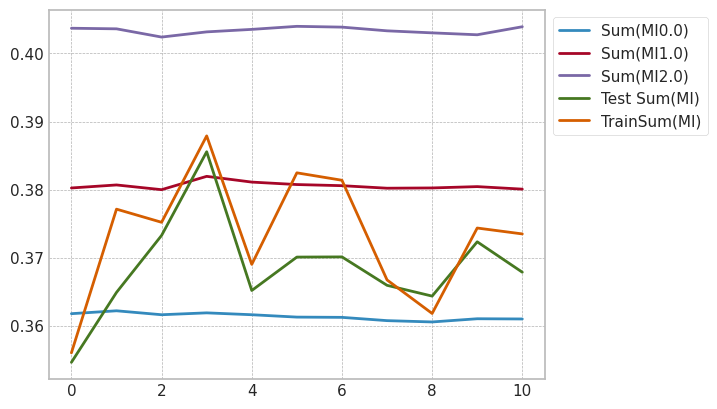

In [69]:
result_df[['Sum(MI0.0)','Sum(MI1.0)','Sum(MI2.0)','Test Sum(MI)','TrainSum(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

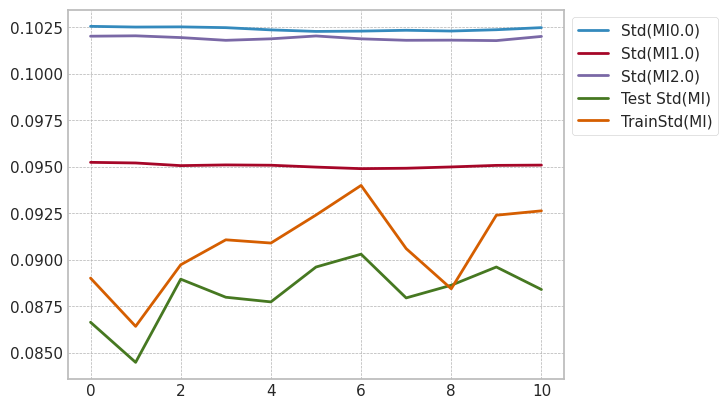

In [70]:
result_df[['Std(MI0.0)','Std(MI1.0)','Std(MI2.0)','Test Std(MI)','TrainStd(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

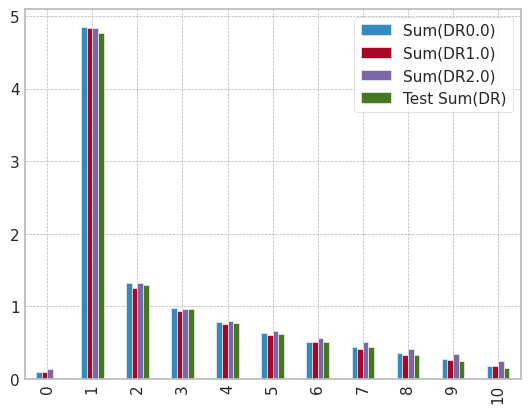

In [71]:
result_df[['Sum(DR0.0)','Sum(DR1.0)','Sum(DR2.0)','Test Sum(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

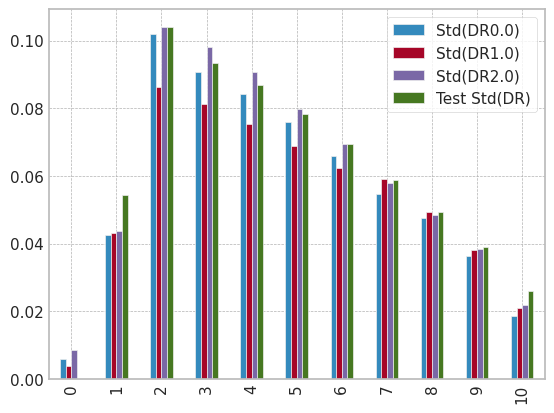

In [72]:
result_df[['Std(DR0.0)','Std(DR1.0)','Std(DR2.0)','Test Std(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [73]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([2.5, 1.2, 0.9 , 1.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 10*cor_const * ii)
    e1 = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)


In [74]:
m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

9.231010910364422


19386

### 실험

MI Analysis MI Max 0.19778, Min 0.00159, Mean 0.07319, Std 0.07958
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:07<00:00,  4.14it/s]


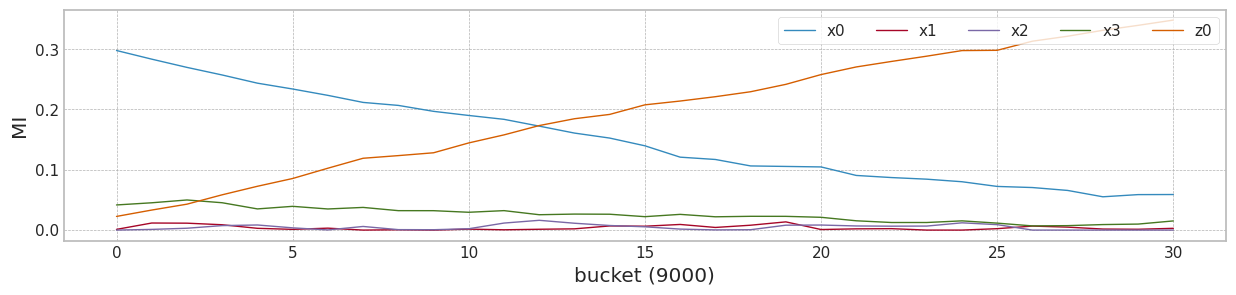

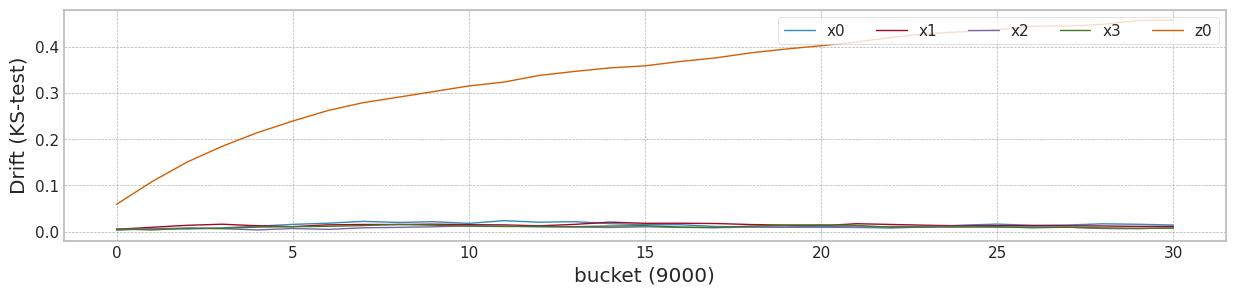

In [75]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X2, y2,train_size, test_size)

In [76]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.410279  0.209059  0.415497  0.727384  0.391721   0
1      0.457001  0.519404  0.479812  0.521037  0.401229   0
2      0.187431  0.428404  0.396307  0.408316  0.393364   0
3      0.676882  0.616554  0.624402  0.490002  0.423167   0
4      0.231854  0.479819  0.377091  0.562758  0.395391   0
...         ...       ...       ...       ...       ...  ..
39995  0.342999  0.553462  0.404624  0.588307 -0.255762  39
39996  0.399868  0.617391  0.449924  0.425269 -0.347659  39
39997  0.389933  0.496568  0.201780  0.495907  1.654762  39
39998  0.407933  0.571901  0.798504  0.658386  0.325860  39
39999  0.425227  0.455123  0.456839  0.491625  0.729285  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 265.77it/s]


Test f1 score: 0.9422071499222835
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.37it/s]


mean of drift:
x0    0.014294
x1    0.014247
x2    0.009111
x3    0.010627
z0    0.336724
dtype: float64
Mean F1 for all data: 0.9378763986662148
######################### Lambda 0.0 ###########################
cpu


100%|██████████| 4000/4000 [01:17<00:00, 51.49it/s]


Test f1 score: 0.9796143250688705
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


mean of drift:
x0    0.718638
x1    0.956573
x2    1.000000
x3    1.000000
z0    0.565505
dtype: float64
Mean F1 for all data: 0.9577918084074837
######################### Lambda 0.1 ###########################
cpu


100%|██████████| 4000/4000 [01:16<00:00, 52.02it/s]


Test f1 score: 0.9687153931339978
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.61it/s]


mean of drift:
x0    0.401358
x1    0.265577
x2    0.355437
x3    0.420742
z0    0.427072
dtype: float64
Mean F1 for all data: 0.9256904297520567
######################### Lambda 0.2 ###########################
cpu


100%|██████████| 4000/4000 [01:15<00:00, 52.81it/s]


Test f1 score: 0.9623454217034876
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.61it/s]


mean of drift:
x0    0.396599
x1    0.152358
x2    0.286147
x3    0.299129
z0    0.413538
dtype: float64
Mean F1 for all data: 0.9308851375014399
######################### Lambda 0.3 ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 55.71it/s]


Test f1 score: 0.9573381195637167
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.89it/s]


mean of drift:
x0    0.341326
x1    0.138631
x2    0.399498
x3    0.263785
z0    0.388136
dtype: float64
Mean F1 for all data: 0.9346488776589156
######################### Lambda 0.4 ###########################
cpu


100%|██████████| 4000/4000 [01:12<00:00, 55.35it/s]


Test f1 score: 0.9546019042362357
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.28it/s]


mean of drift:
x0    0.259480
x1    0.119871
x2    0.093366
x3    0.202122
z0    0.369337
dtype: float64
Mean F1 for all data: 0.9429274219613087
######################### Lambda 0.5 ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 56.02it/s]


Test f1 score: 0.9523151347615758
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


mean of drift:
x0    0.221685
x1    0.096882
x2    0.061072
x3    0.164932
z0    0.360817
dtype: float64
Mean F1 for all data: 0.9426213402839898
######################### Lambda 0.6 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.65it/s]


Test f1 score: 0.944905869324474
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.138104
x1    0.076391
x2    0.031176
x3    0.118065
z0    0.355280
dtype: float64
Mean F1 for all data: 0.9457187018473259
######################### Lambda 0.7 ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 56.29it/s]


Test f1 score: 0.9420249653259364
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.61it/s]


mean of drift:
x0    0.103154
x1    0.058111
x2    0.023860
x3    0.087430
z0    0.350029
dtype: float64
Mean F1 for all data: 0.9437492552821398
######################### Lambda 0.8 ###########################
cpu


100%|██████████| 4000/4000 [01:07<00:00, 59.33it/s]


Test f1 score: 0.9389228206551916
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.49it/s]


mean of drift:
x0    0.108530
x1    0.042000
x2    0.017968
x3    0.058072
z0    0.347168
dtype: float64
Mean F1 for all data: 0.9388868717173793
######################### Lambda 0.9 ###########################
cpu


100%|██████████| 4000/4000 [01:08<00:00, 58.11it/s]


Test f1 score: 0.9412749337425025
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


mean of drift:
x0    0.083652
x1    0.026968
x2    0.013903
x3    0.036459
z0    0.342896
dtype: float64
Mean F1 for all data: 0.937072459743314


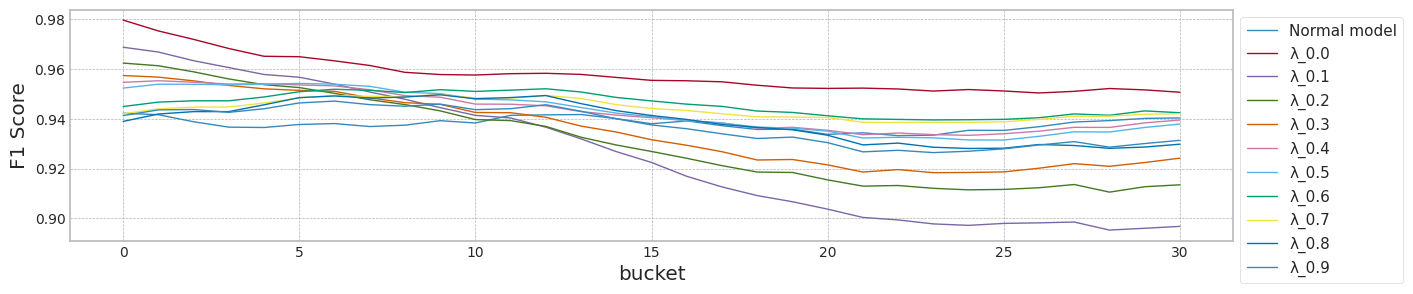

max_mean_lambda= 0.0


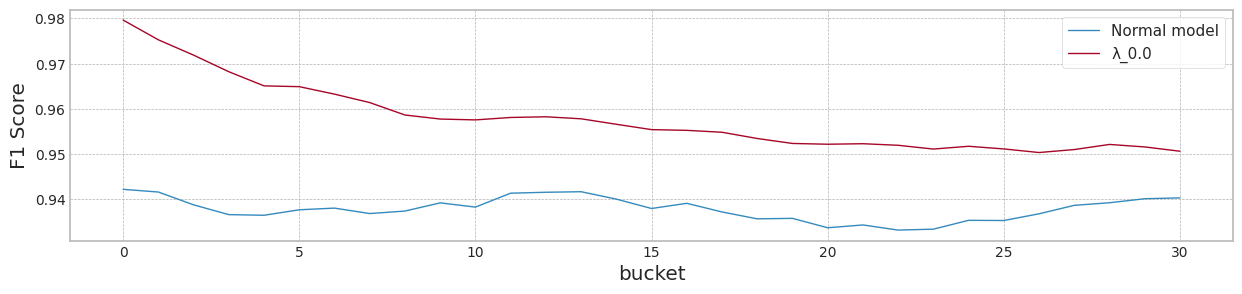

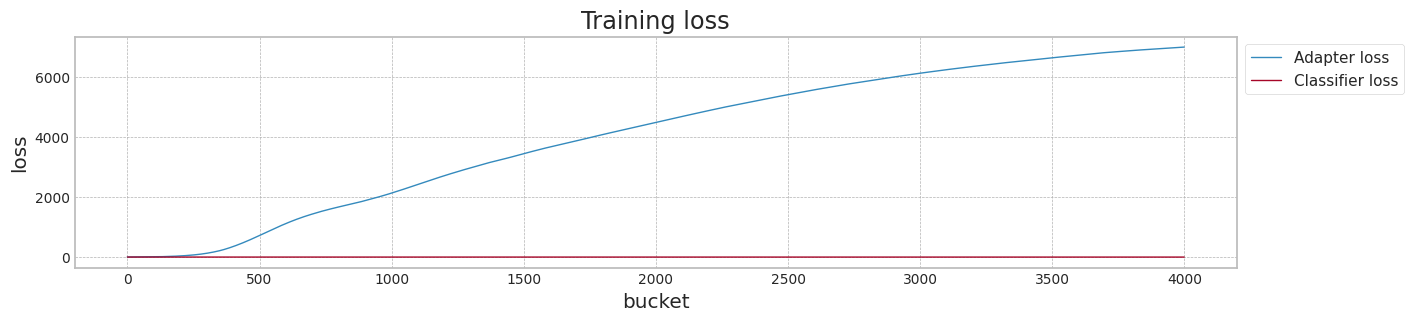

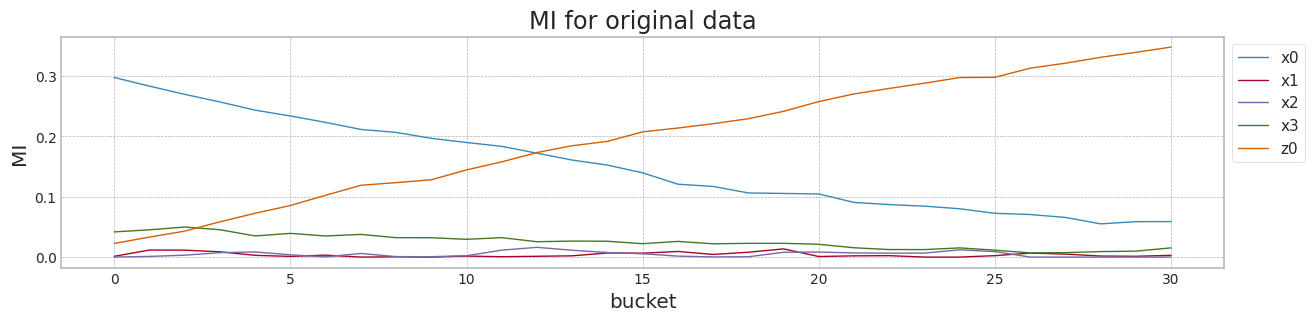

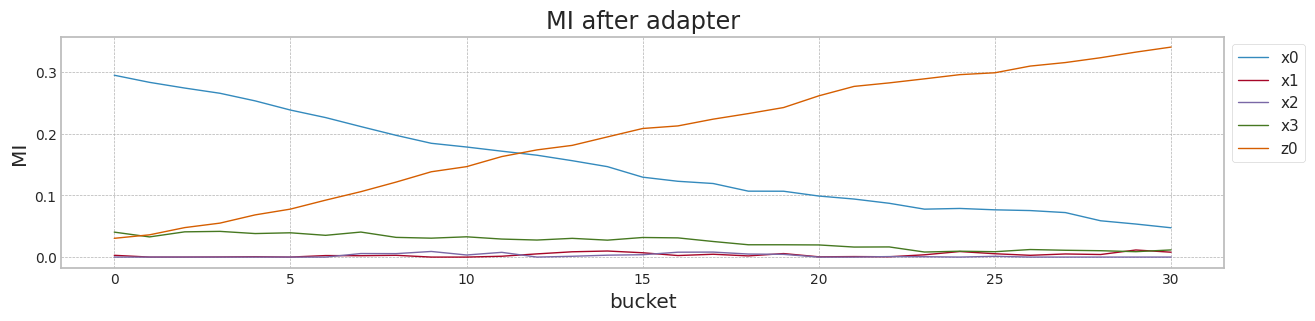

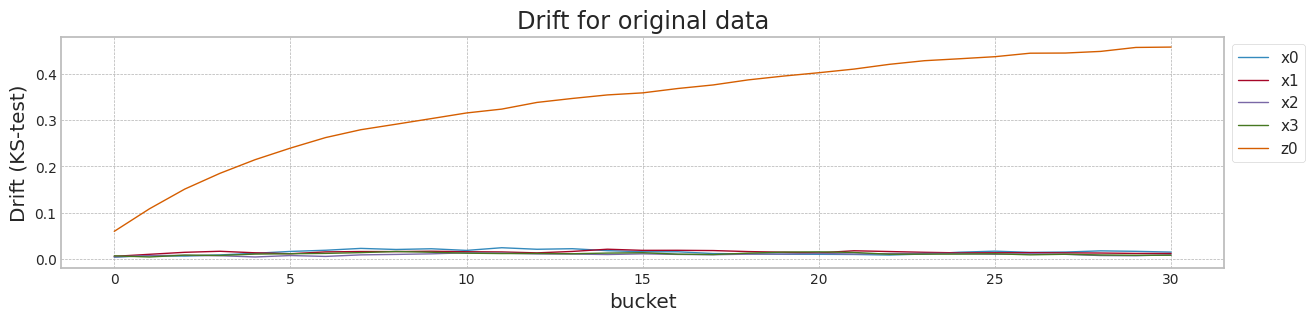

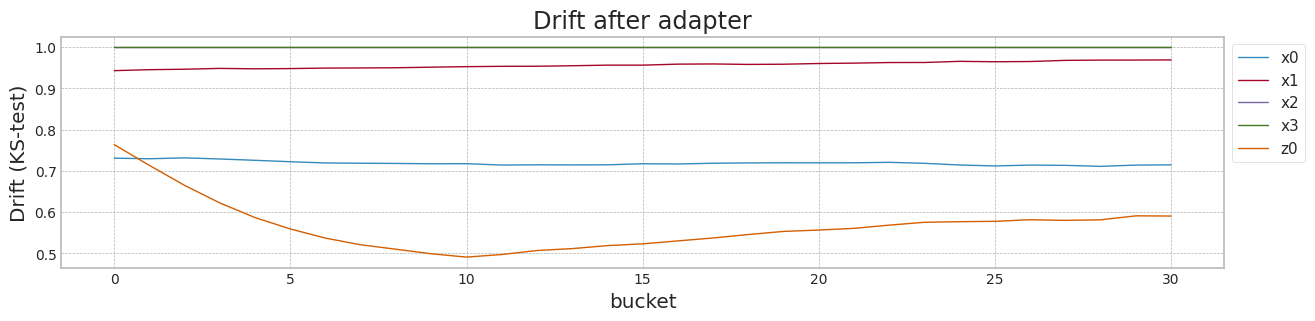

['Sum(MI0.0)', 'Sum(MI1.0)', 'Sum(MI2.0)', 'Sum(MI3.0)', 'Sum(MI4.0)', 'Sum(MI5.0)', 'Sum(MI6.0)', 'Sum(MI7.0)', 'Sum(MI8.0)', 'Test Sum(MI)', 'TrainSum(MI)']
1     0.033759
2     0.032556
3     0.032896
4     0.032381
5     0.032267
6     0.032549
7     0.031904
8     0.032865
9     0.033406
10    0.032496
dtype: float64
best_lambda= 0


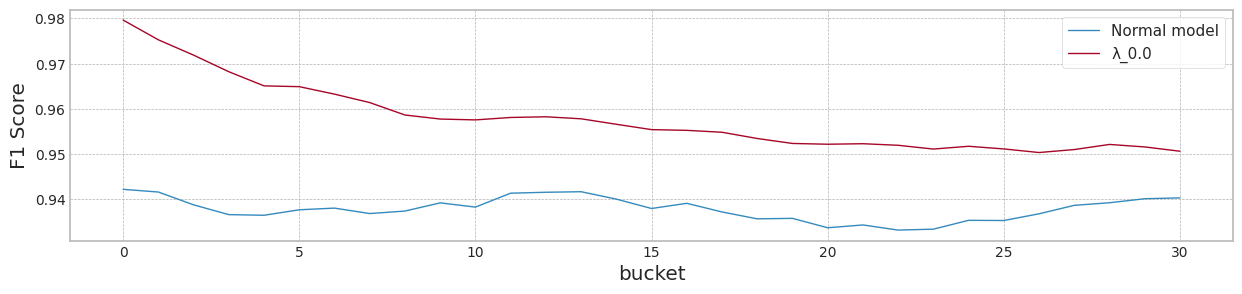

best_lambda= 6


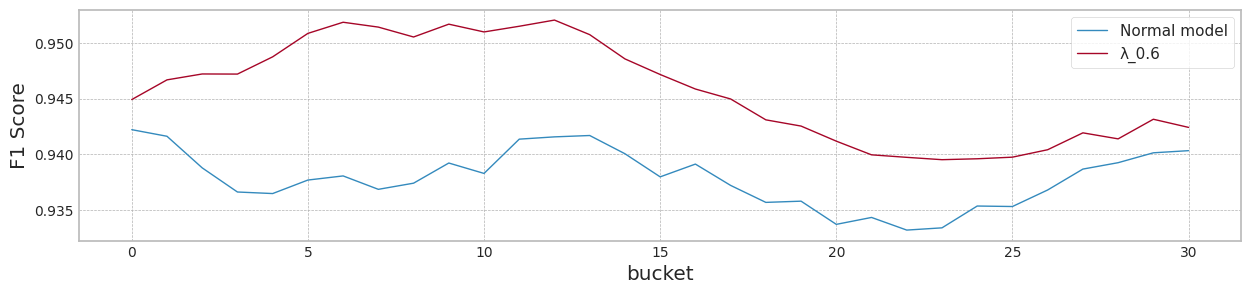

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.942207  0.942207  0.937876  0.940325    0.382206   
1                     0.0  0.979614  0.979614  0.957792  0.950632    0.382567   
2                     0.1  0.968715  0.968715  0.925690  0.896766    0.382405   
3                     0.2  0.962345  0.962345  0.930885  0.913466    0.381962   
4                     0.3  0.957338  0.957338  0.934649  0.924173    0.380661   
5                     0.4  0.954602  0.954602  0.942927  0.939484    0.381923   
6                     0.5  0.952315  0.952315  0.942621  0.937862    0.382731   
7                     0.6  0.944906  0.944906  0.945719  0.942411    0.381563   
8                     0.7  0.942025  0.942025  0.943749  0.942026    0.382937   
9                     0.8  0.938923  0.938923  0.938887  0.929784    0.380731   
10                    0.9  0.941275  0.941275  0.937072  0.931322    0.382300   

    Std(MI0.0)  Sum(DR0.0)  Std(DR0.0)  Sum(MI1.0)  ...  Sum(MI8.0)  \
0     0.125230    0.477000    0.135991    0.451062  ...    0.322735   
1     0.125178    4.682667    0.096302    0.451169  ...    0.323215   
2     0.124803    1.765000    0.175596    0.450241  ...    0.322785   
3     0.124728    1.344222    0.081576    0.450088  ...    0.321398   
4     0.124694    1.295444    0.085698    0.449856  ...    0.321724   
5     0.124658    1.133111    0.136225    0.450764  ...    0.321939   
6     0.124611    0.986889    0.128157    0.450889  ...    0.322294   
7     0.124874    0.905444    0.125247    0.450065  ...    0.322999   
8     0.124865    0.802889    0.123778    0.450384  ...    0.321943   
9     0.125192    0.707111    0.126918    0.451361  ...    0.322159   
10    0.124932    0.589444    0.131672    0.450751  ...    0.322217   

    Std(MI8.0)  Sum(DR8.0)  Std(DR8.0)  TrainSum(MI)  TrainStd(MI)  \
0     0.094687    0.306444    0.076937      0.379631      0.116674   
1     0.094650    4.264222    0.166000      0.387379      0.115892   
2     0.094586    1.386111    0.074017      0.400518      0.115074   
3     0.094557    1.304222    0.064199      0.392204      0.112197   
4     0.094403    1.235778    0.099012      0.408085      0.115699   
5     0.094552    0.819889    0.069382      0.405106      0.111768   
6     0.094493    0.702000    0.070291      0.414820      0.115997   
7     0.094720    0.620111    0.071062      0.403456      0.114712   
8     0.094584    0.521667    0.071179      0.392264      0.121000   
9     0.094502    0.430889    0.073892      0.390420      0.115989   
10    0.094502    0.361000    0.076334      0.404595      0.116465   

    Test Sum(MI)  Test Std(MI)  Test Sum(DR)  Test Std(DR)  
0       0.363392      0.113602      0.000000      0.000000  
1       0.367956      0.111498      4.436444      0.117073  
2       0.383567      0.109717      1.325111      0.087643  
3       0.381505      0.107212      1.176667      0.064424  
4       0.401074      0.109321      1.107111      0.089123  
5       0.394970      0.106481      0.778111      0.072829  
6       0.392525      0.111025      0.644222      0.064816  
7       0.404303      0.108536      0.551556      0.060161  
8       0.379910      0.115044      0.432556      0.051529  
9       0.374083      0.110334      0.308111      0.043228  
10      0.387264      0.110532      0.174778      0.029912  

[11 rows x 47 columns]

In [77]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

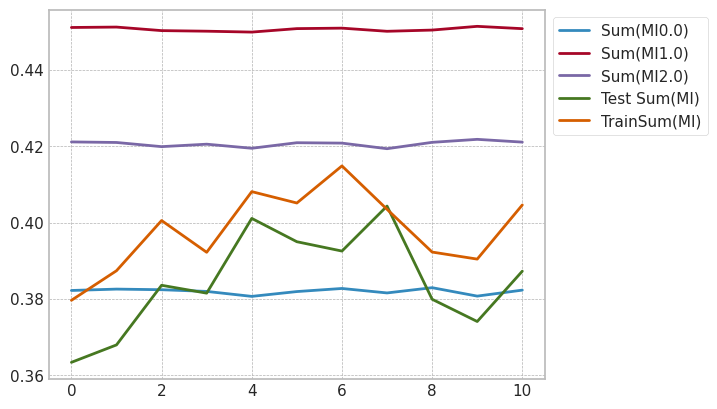

In [78]:
result_df[['Sum(MI0.0)','Sum(MI1.0)','Sum(MI2.0)','Test Sum(MI)','TrainSum(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

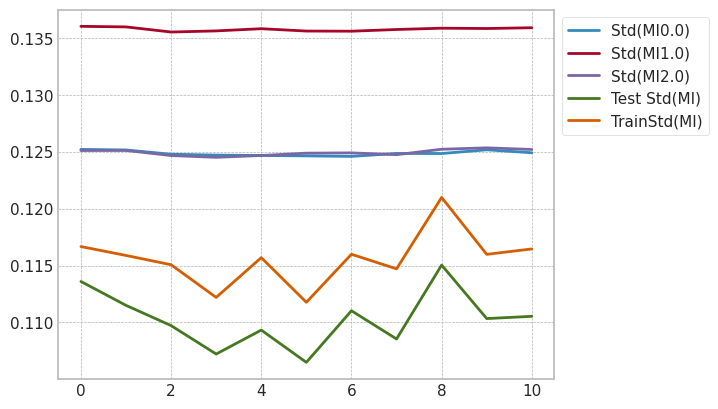

In [79]:
result_df[['Std(MI0.0)','Std(MI1.0)','Std(MI2.0)','Test Std(MI)','TrainStd(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

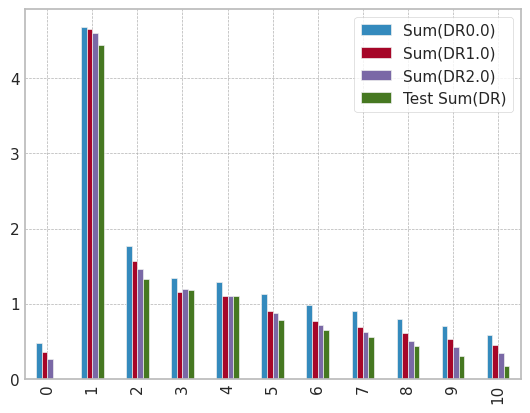

In [80]:
result_df[['Sum(DR0.0)','Sum(DR1.0)','Sum(DR2.0)','Test Sum(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

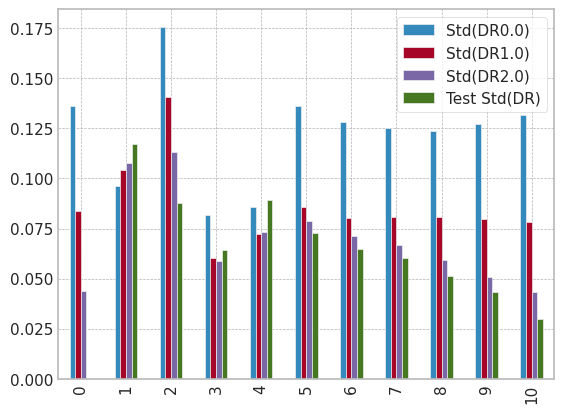

In [81]:
result_df[['Std(DR0.0)','Std(DR1.0)','Std(DR2.0)','Test Std(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [82]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:08<00:00,  3.75it/s]


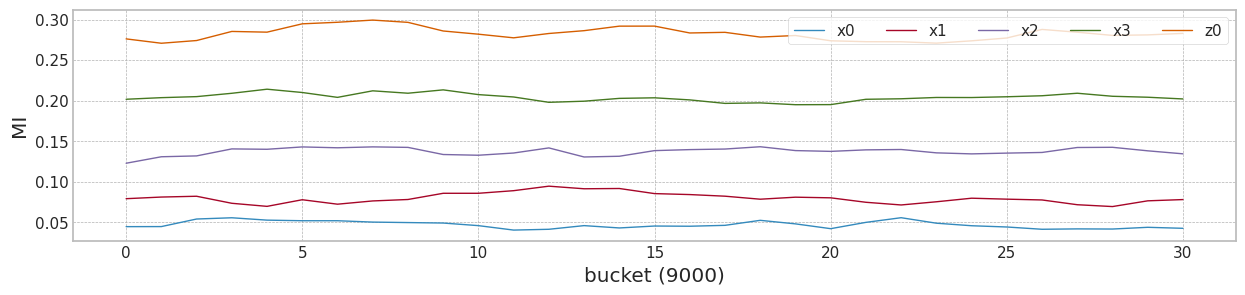

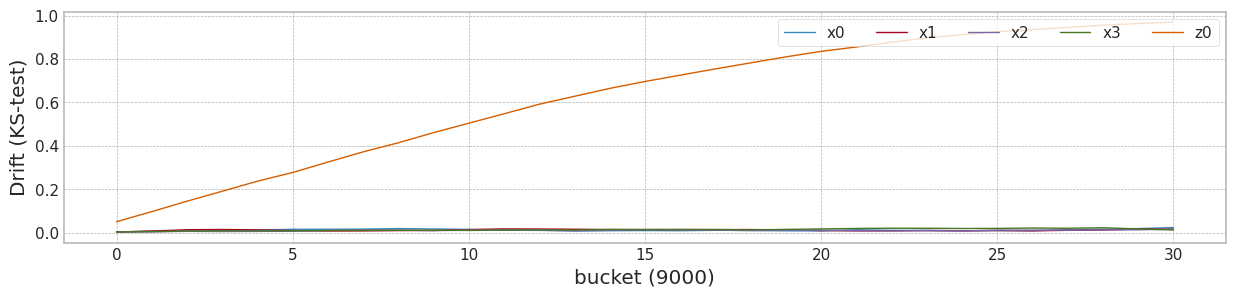

In [83]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [84]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.477486   0
1      0.447230  0.556479  0.629077  0.735705  0.578715   0
2      0.489501  0.704159  0.760582  0.582973  0.354045   0
3      0.581446  0.301839  0.443337  0.515173  0.360338   0
4      0.571642  0.639275  0.524701  0.583380  0.597569   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.989291  39
39996  0.426322  0.302644  0.484909  0.587518  1.004704  39
39997  0.374186  0.587769  0.624447  0.598315  1.321791  39
39998  0.470439  0.265430  0.218971  0.645349  1.148847  39
39999  0.654583  0.419378  0.800216  0.614031  1.319193  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 257.81it/s]


Test f1 score: 0.9102426454799226
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.24it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.760588938342107
######################### Lambda 0.0 ###########################
cpu


100%|██████████| 4000/4000 [01:20<00:00, 50.00it/s]


Test f1 score: 0.9215686274509803
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.61it/s]


mean of drift:
x0    1.000000
x1    0.999986
x2    1.000000
x3    1.000000
z0    0.943050
dtype: float64
Mean F1 for all data: 0.9233046236021019
######################### Lambda 0.1 ###########################
cpu


100%|██████████| 4000/4000 [01:19<00:00, 50.21it/s]


Test f1 score: 0.9212147887323943
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.04it/s]


mean of drift:
x0    0.629487
x1    0.287319
x2    0.270448
x3    0.284516
z0    0.295649
dtype: float64
Mean F1 for all data: 0.9002382065165307
######################### Lambda 0.2 ###########################
cpu


100%|██████████| 4000/4000 [01:17<00:00, 51.58it/s]


Test f1 score: 0.9216376843495487
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.42it/s]


mean of drift:
x0    0.456584
x1    0.251753
x2    0.225756
x3    0.314254
z0    0.305290
dtype: float64
Mean F1 for all data: 0.920058310129946
######################### Lambda 0.3 ###########################
cpu


100%|██████████| 4000/4000 [01:15<00:00, 53.17it/s]


Test f1 score: 0.9194770954630342
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.21it/s]


mean of drift:
x0    0.585075
x1    0.206115
x2    0.238842
x3    0.290900
z0    0.314624
dtype: float64
Mean F1 for all data: 0.9187044680486104
######################### Lambda 0.4 ###########################
cpu


100%|██████████| 4000/4000 [01:12<00:00, 54.80it/s]


Test f1 score: 0.916941331575478
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.64it/s]


mean of drift:
x0    0.425889
x1    0.240606
x2    0.252677
x3    0.295047
z0    0.335541
dtype: float64
Mean F1 for all data: 0.9167328699887314
######################### Lambda 0.5 ###########################
cpu


100%|██████████| 4000/4000 [01:13<00:00, 54.69it/s]


Test f1 score: 0.915562369948527
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.63it/s]


mean of drift:
x0    0.093978
x1    0.230061
x2    0.239993
x3    0.302652
z0    0.327462
dtype: float64
Mean F1 for all data: 0.9164502436456697
######################### Lambda 0.6 ###########################
cpu


100%|██████████| 4000/4000 [01:10<00:00, 56.65it/s]


Test f1 score: 0.920589841616603
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.43it/s]


mean of drift:
x0    0.087222
x1    0.216602
x2    0.210885
x3    0.261556
z0    0.331577
dtype: float64
Mean F1 for all data: 0.9187651081370587
######################### Lambda 0.7 ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 56.13it/s]


Test f1 score: 0.9217182730047973
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


mean of drift:
x0    0.111280
x1    0.174595
x2    0.188982
x3    0.241491
z0    0.364165
dtype: float64
Mean F1 for all data: 0.9117755204562292
######################### Lambda 0.8 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.39it/s]


Test f1 score: 0.9210211841390549
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


mean of drift:
x0    0.096957
x1    0.144978
x2    0.175251
x3    0.214262
z0    0.429254
dtype: float64
Mean F1 for all data: 0.8893341877840212
######################### Lambda 0.9 ###########################
cpu


100%|██████████| 4000/4000 [01:08<00:00, 58.52it/s]


Test f1 score: 0.9187729531216244
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.71it/s]


mean of drift:
x0    0.070004
x1    0.101728
x2    0.117115
x3    0.150290
z0    0.511824
dtype: float64
Mean F1 for all data: 0.8391276733259472


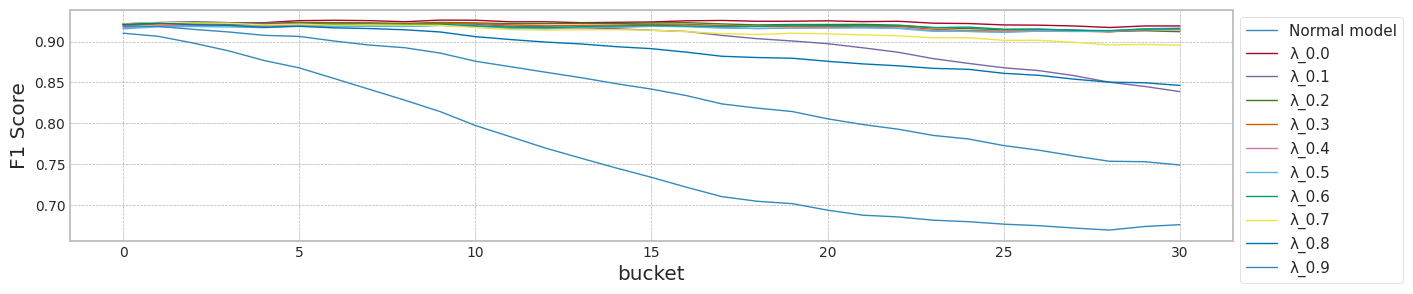

max_mean_lambda= 0.0


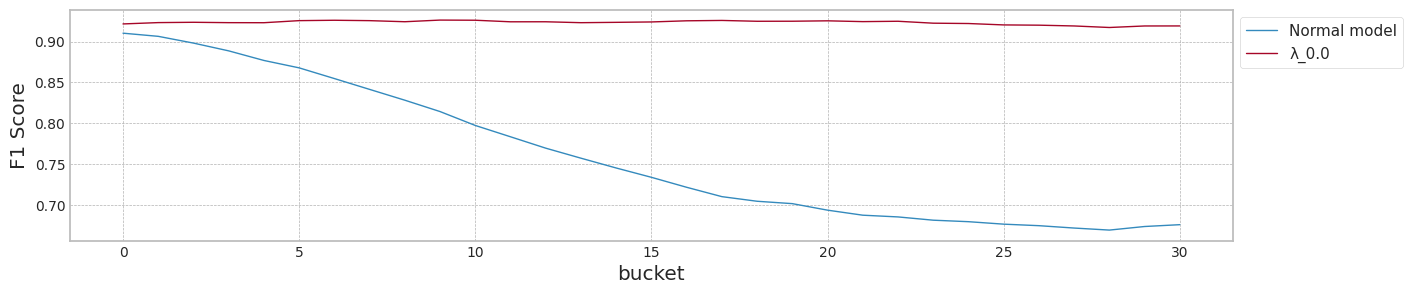

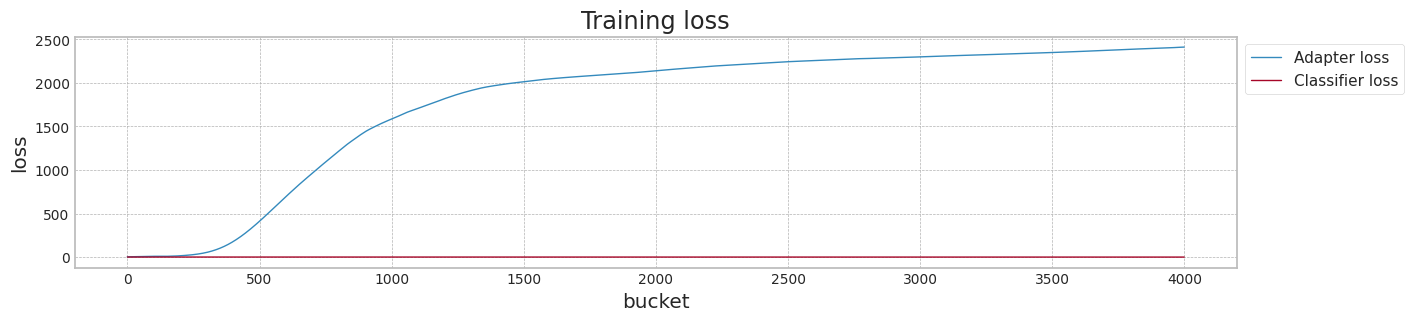

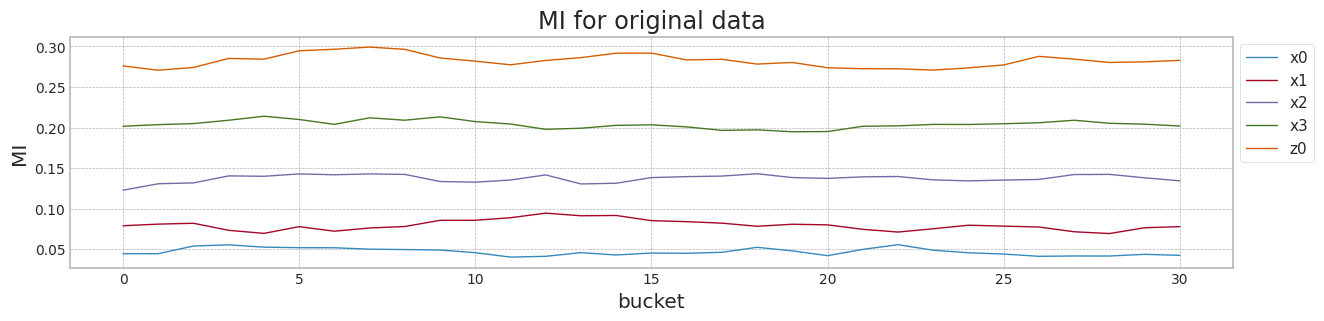

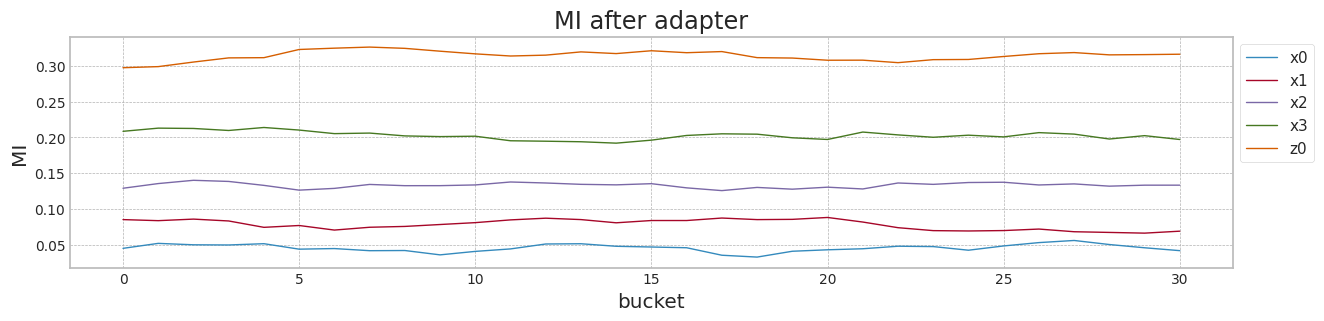

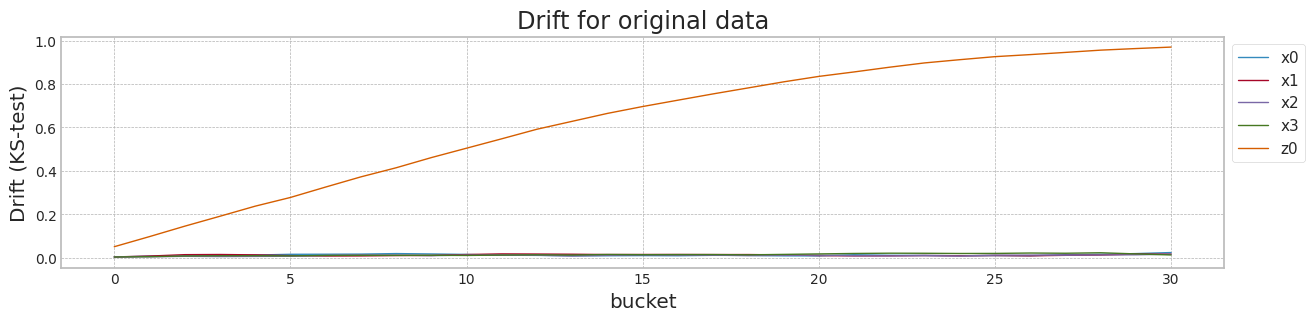

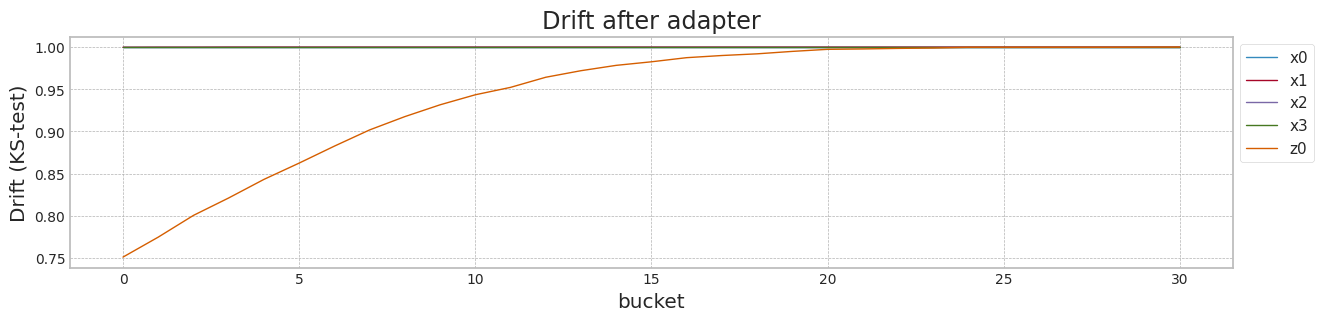

['Sum(MI0.0)', 'Sum(MI1.0)', 'Sum(MI2.0)', 'Sum(MI3.0)', 'Sum(MI4.0)', 'Sum(MI5.0)', 'Sum(MI6.0)', 'Sum(MI7.0)', 'Sum(MI8.0)', 'Test Sum(MI)', 'TrainSum(MI)']
1     0.024426
2     0.022702
3     0.022223
4     0.022162
5     0.021885
6     0.021820
7     0.022649
8     0.022520
9     0.021512
10    0.023645
dtype: float64
best_lambda= 0


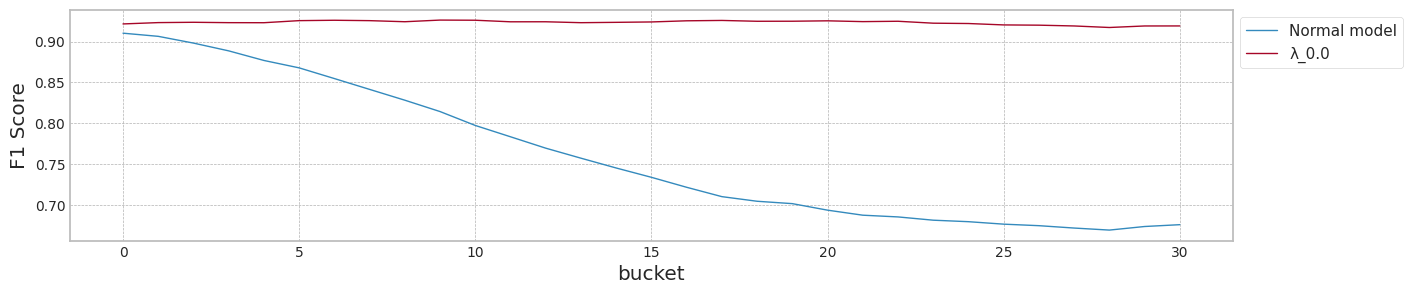

best_lambda= 8


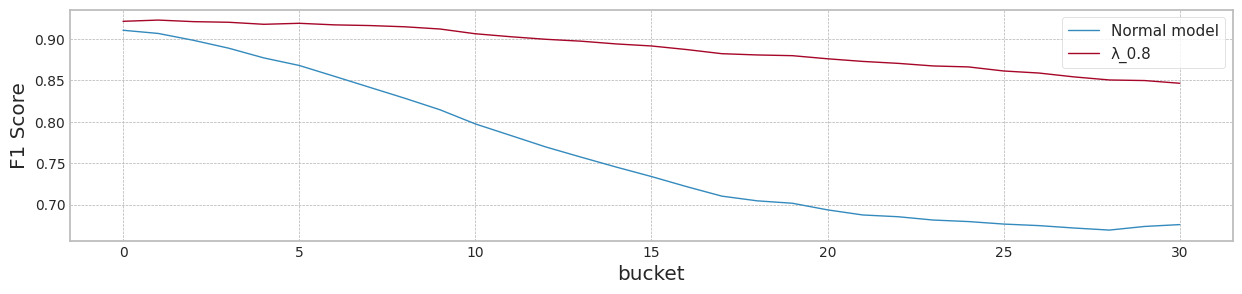

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.910243  0.910243  0.760589  0.675771    0.804112   
1                     0.0  0.921569  0.921569  0.923305  0.919116    0.803738   
2                     0.1  0.921215  0.921215  0.900238  0.838694    0.804231   
3                     0.2  0.921638  0.921638  0.920058  0.912056    0.802175   
4                     0.3  0.919477  0.919477  0.918704  0.914856    0.802458   
5                     0.4  0.916941  0.916941  0.916733  0.914455    0.803748   
6                     0.5  0.915562  0.915562  0.916450  0.916499    0.802516   
7                     0.6  0.920590  0.920590  0.918765  0.915733    0.803994   
8                     0.7  0.921718  0.921718  0.911776  0.895478    0.803545   
9                     0.8  0.921021  0.921021  0.889334  0.846261    0.803885   
10                    0.9  0.918773  0.918773  0.839128  0.748854    0.803783   

    Std(MI0.0)  Sum(DR0.0)  Std(DR0.0)  Sum(MI1.0)  ...  Sum(MI8.0)  \
0     0.112842    0.302111    0.076825    0.754068  ...    0.799794   
1     0.112861    4.621222    0.151511    0.753716  ...    0.798895   
2     0.112703    1.081667    0.058806    0.754878  ...    0.797362   
3     0.112957    1.003778    0.091462    0.755246  ...    0.785418   
4     0.112995    1.136444    0.141102    0.728677  ...    0.782808   
5     0.113018    0.941667    0.094034    0.755550  ...    0.799872   
6     0.112360    0.613222    0.062872    0.753638  ...    0.798808   
7     0.112800    0.523333    0.065071    0.754090  ...    0.799555   
8     0.113059    0.479778    0.063954    0.752895  ...    0.799723   
9     0.112919    0.407778    0.057204    0.754355  ...    0.798930   
10    0.113036    0.328778    0.062054    0.753419  ...    0.799683   

    Std(MI8.0)  Sum(DR8.0)  Std(DR8.0)  TrainSum(MI)  TrainStd(MI)  \
0     0.107014    0.300333    0.074507      0.738968      0.084225   
1     0.107142    4.836333    0.065467      0.769092      0.092198   
2     0.107299    1.064556    0.019212      0.803823      0.098736   
3     0.110105    1.142000    0.088267      0.810321      0.099353   
4     0.110558    1.239889    0.131965      0.784334      0.100921   
5     0.106659    1.073889    0.088814      0.787333      0.098811   
6     0.106843    0.741889    0.035865      0.804159      0.095028   
7     0.106732    0.595444    0.045780      0.787444      0.092170   
8     0.107054    0.540667    0.043148      0.782405      0.094881   
9     0.106927    0.471889    0.046720      0.795763      0.092300   
10    0.107045    0.381000    0.053336      0.774989      0.088859   

    Test Sum(MI)  Test Std(MI)  Test Sum(DR)  Test Std(DR)  
0       0.723681      0.084119      0.000000      0.000000  
1       0.765124      0.090288      4.752000      0.099089  
2       0.818955      0.096816      1.024444      0.035384  
3       0.807889      0.098090      1.011667      0.082135  
4       0.782949      0.099460      1.124778      0.137623  
5       0.784413      0.099063      0.933444      0.093818  
6       0.801111      0.094436      0.608667      0.034108  
7       0.775430      0.094611      0.453000      0.039996  
8       0.782812      0.094663      0.373111      0.029518  
9       0.782912      0.092701      0.272000      0.022173  
10      0.767640      0.084715      0.152889      0.011205  

[11 rows x 47 columns]

In [85]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

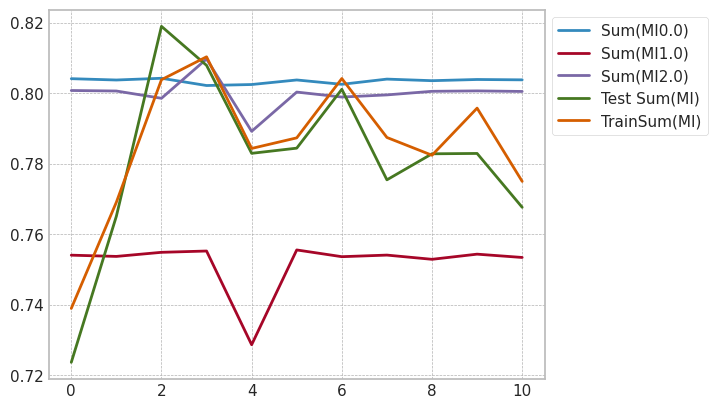

In [86]:
result_df[['Sum(MI0.0)','Sum(MI1.0)','Sum(MI2.0)','Test Sum(MI)','TrainSum(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [87]:
np.argmax(np.std(result_df[['Sum(MI0.0)','Sum(MI1.0)','Sum(MI2.0)','Test Sum(MI)']],axis=1))

0

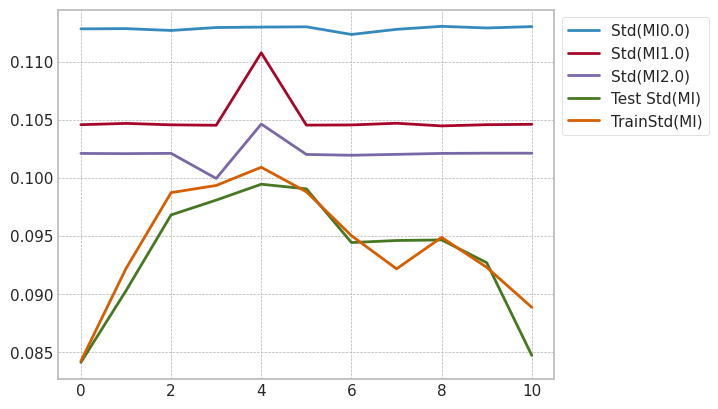

In [88]:
result_df[['Std(MI0.0)','Std(MI1.0)','Std(MI2.0)','Test Std(MI)','TrainStd(MI)']].plot()
plt.legend(bbox_to_anchor=(1.0, 1.0))

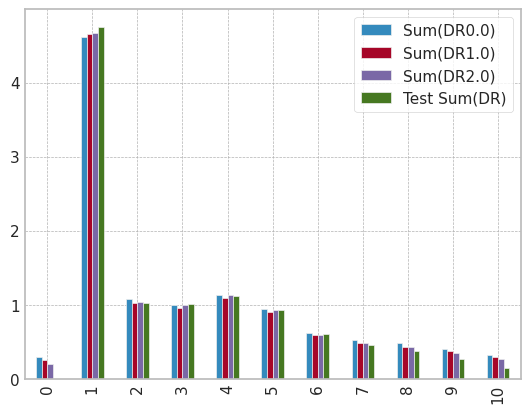

In [89]:
result_df[['Sum(DR0.0)','Sum(DR1.0)','Sum(DR2.0)','Test Sum(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

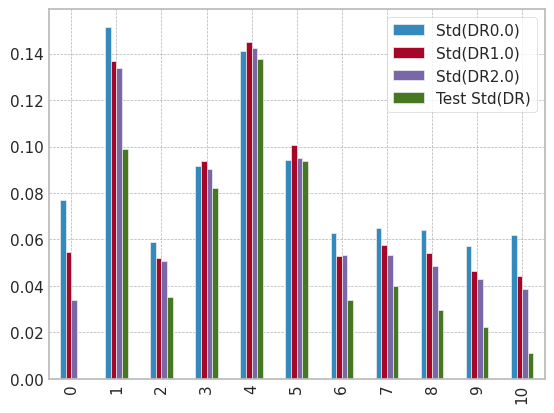

In [90]:
result_df[['Std(DR0.0)','Std(DR1.0)','Std(DR2.0)','Test Std(DR)']].plot.bar()
plt.legend(bbox_to_anchor=(1.0, 1.0))

## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [91]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:08<00:00,  3.73it/s]


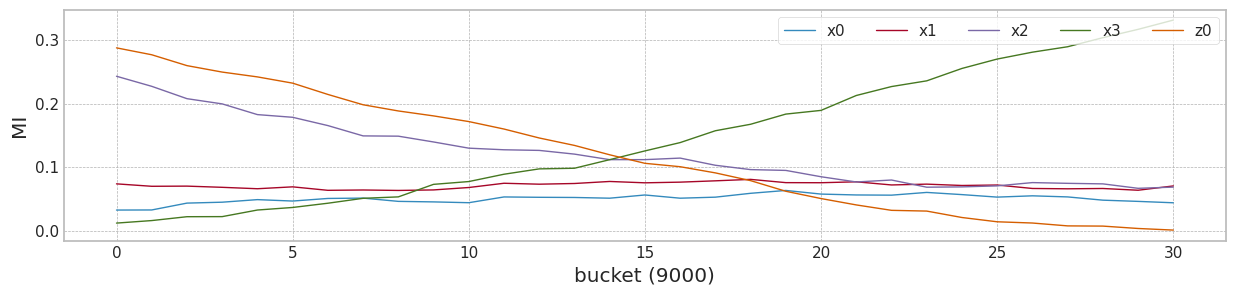

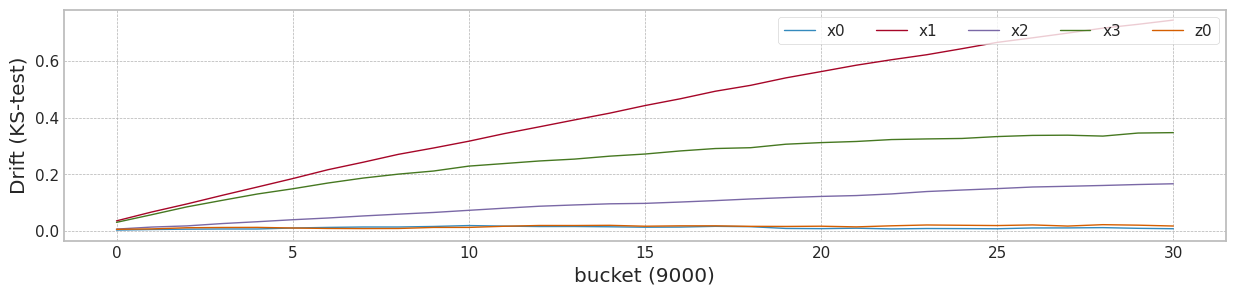

In [92]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 259.33it/s]


Test f1 score: 0.9227268417559494
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  3.92it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7642579759110337
######################### Lambda 0.0 ###########################
cpu


100%|██████████| 4000/4000 [01:20<00:00, 49.69it/s]


Test f1 score: 0.940003870718018
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:09<00:00,  3.27it/s]


mean of drift:
x0    0.999993
x1    0.934953
x2    1.000000
x3    1.000000
z0    0.597394
dtype: float64
Mean F1 for all data: 0.8560189476347281
######################### Lambda 0.1 ###########################
cpu


100%|██████████| 4000/4000 [01:17<00:00, 51.31it/s]


Test f1 score: 0.9391304347826087
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:07<00:00,  4.01it/s]


mean of drift:
x0    0.260437
x1    0.239832
x2    0.319151
x3    0.336509
z0    0.333871
dtype: float64
Mean F1 for all data: 0.8677525823754842
######################### Lambda 0.2 ###########################
cpu


100%|██████████| 4000/4000 [01:16<00:00, 52.48it/s]


Test f1 score: 0.9373549883990719
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]


mean of drift:
x0    0.268118
x1    0.287663
x2    0.290720
x3    0.271405
z0    0.287663
dtype: float64
Mean F1 for all data: 0.859748965084689
######################### Lambda 0.3 ###########################
cpu


100%|██████████| 4000/4000 [01:14<00:00, 53.44it/s]


Test f1 score: 0.9300498275201227
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.64it/s]


mean of drift:
x0    0.233014
x1    0.284785
x2    0.305444
x3    0.404373
z0    0.198237
dtype: float64
Mean F1 for all data: 0.818736949077232
######################### Lambda 0.4 ###########################
cpu


100%|██████████| 4000/4000 [01:12<00:00, 55.50it/s]


Test f1 score: 0.9288854903460141
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.63it/s]


mean of drift:
x0    0.211498
x1    0.309964
x2    0.290305
x3    0.548849
z0    0.265774
dtype: float64
Mean F1 for all data: 0.7941036389800508
######################### Lambda 0.5 ###########################
cpu


100%|██████████| 4000/4000 [01:12<00:00, 55.14it/s]


Test f1 score: 0.9264663805436337
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.45it/s]


mean of drift:
x0    0.173692
x1    0.325258
x2    0.263731
x3    0.223473
z0    0.239996
dtype: float64
Mean F1 for all data: 0.7785595380351046
######################### Lambda 0.6 ###########################
cpu


100%|██████████| 4000/4000 [01:11<00:00, 55.83it/s]


Test f1 score: 0.9233985934233035
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.60it/s]


mean of drift:
x0    0.142638
x1    0.341229
x2    0.274914
x3    0.195305
z0    0.216337
dtype: float64
Mean F1 for all data: 0.758631194574198
######################### Lambda 0.7 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.54it/s]


Test f1 score: 0.9202919154582504
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.46it/s]


mean of drift:
x0    0.104606
x1    0.356448
x2    0.228642
x3    0.202401
z0    0.181978
dtype: float64
Mean F1 for all data: 0.7407597143423145
######################### Lambda 0.8 ###########################
cpu


100%|██████████| 4000/4000 [01:09<00:00, 57.16it/s]


Test f1 score: 0.9165092557612391
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:08<00:00,  3.64it/s]


mean of drift:
x0    0.063556
x1    0.371186
x2    0.156728
x3    0.217860
z0    0.133419
dtype: float64
Mean F1 for all data: 0.732959361709061
######################### Lambda 0.9 ###########################
cpu


100%|██████████| 4000/4000 [01:08<00:00, 58.08it/s]


Test f1 score: 0.9129535626997556
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.44it/s]


mean of drift:
x0    0.034043
x1    0.394405
x2    0.140301
x3    0.232918
z0    0.092674
dtype: float64
Mean F1 for all data: 0.7225793717739919


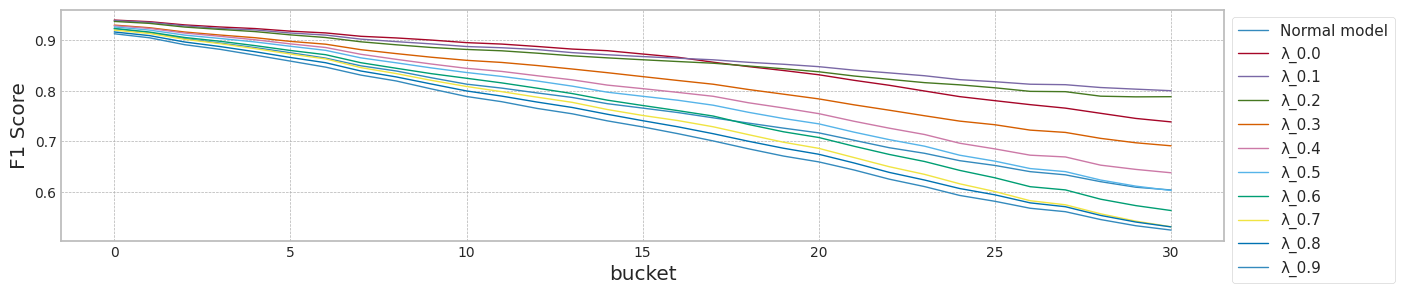

max_mean_lambda= 0.1


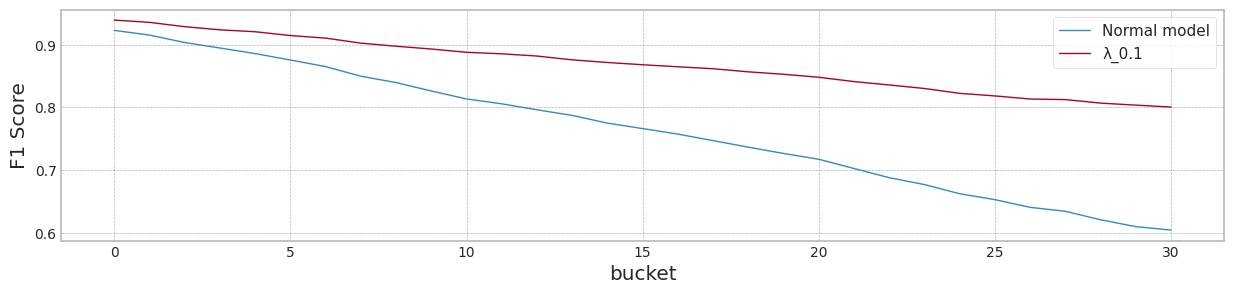

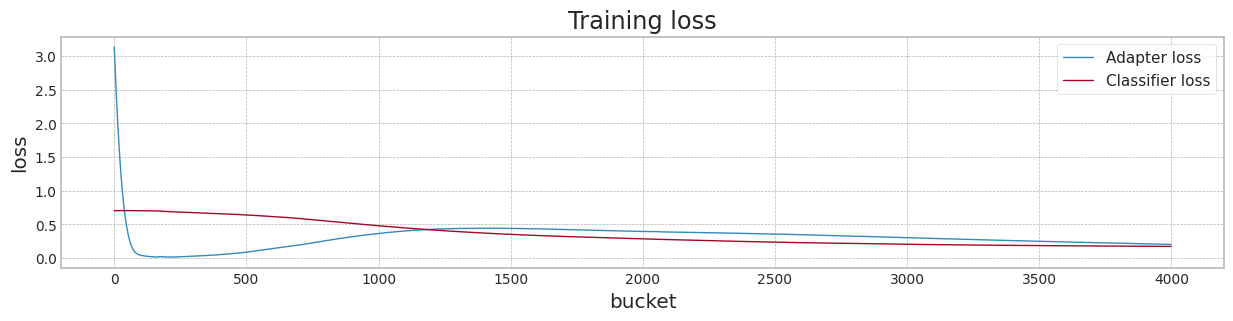

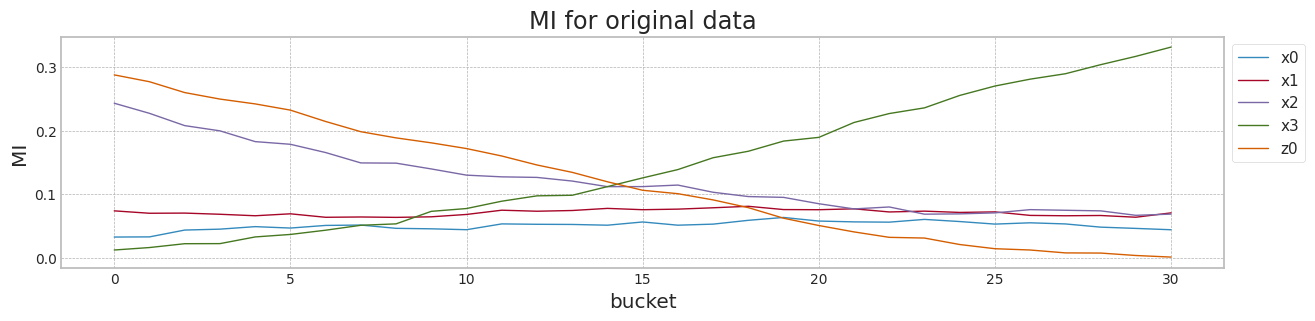

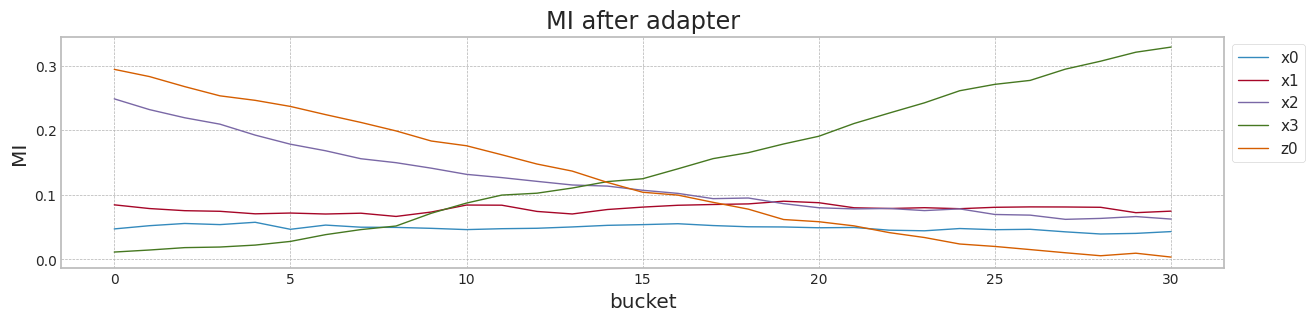

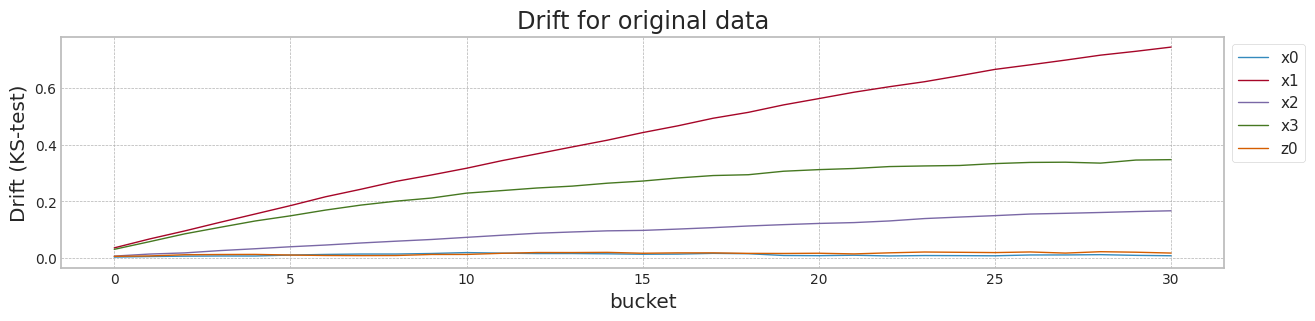

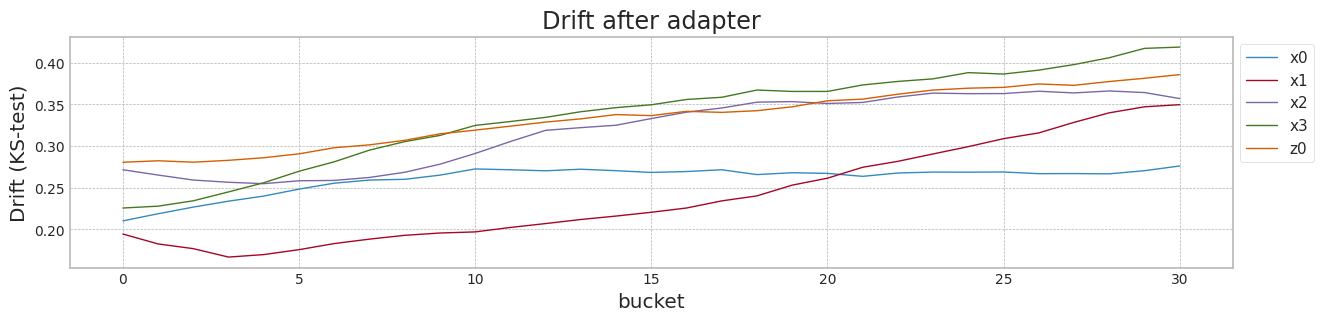

['Sum(MI0.0)', 'Sum(MI1.0)', 'Sum(MI2.0)', 'Sum(MI3.0)', 'Sum(MI4.0)', 'Sum(MI5.0)', 'Sum(MI6.0)', 'Sum(MI7.0)', 'Sum(MI8.0)', 'Test Sum(MI)', 'TrainSum(MI)']
1     0.045524
2     0.033679
3     0.034354
4     0.034440
5     0.034657
6     0.034560
7     0.035310
8     0.036488
9     0.037272
10    0.035753
dtype: float64
best_lambda= 0


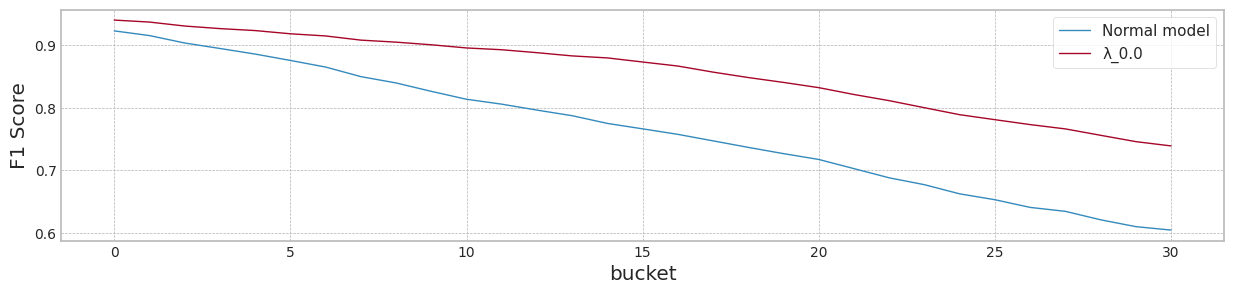

best_lambda= 1


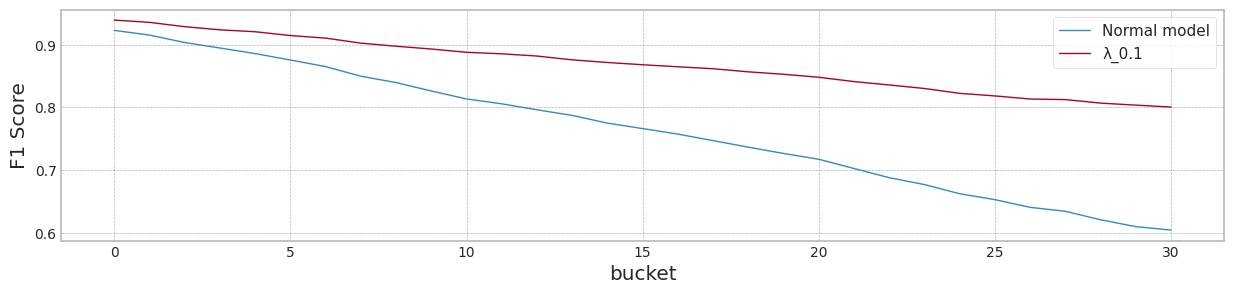

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.922727  0.922727  0.764258  0.604010    0.740659   
1                     0.0  0.940004  0.940004  0.856019  0.738656    0.740515   
2                     0.1  0.939130  0.939130  0.867753  0.800350    0.739542   
3                     0.2  0.937355  0.937355  0.859749  0.788494    0.738053   
4                     0.3  0.930050  0.930050  0.818737  0.691396    0.739700   
5                     0.4  0.928885  0.928885  0.794104  0.638059    0.738819   
6                     0.5  0.926466  0.926466  0.778560  0.603016    0.739488   
7                     0.6  0.923399  0.923399  0.758631  0.563397    0.741095   
8                     0.7  0.920292  0.920292  0.740760  0.531281    0.739246   
9                     0.8  0.916509  0.916509  0.732959  0.531032    0.739050   
10                    0.9  0.912954  0.912954  0.722579  0.524748    0.740326   

    Std(MI0.0)  Sum(DR0.0)  Std(DR0.0)  Sum(MI1.0)  ...  Sum(MI8.0)  \
0     0.147834    0.341000    0.052764    0.748742  ...    0.669602   
1     0.147841    4.719222    0.110541    0.748692  ...    0.669727   
2     0.147787    1.288222    0.044947    0.748744  ...    0.669356   
3     0.147956    1.162667    0.088996    0.748049  ...    0.670629   
4     0.147585    1.256667    0.133234    0.748201  ...    0.668642   
5     0.147681    1.156222    0.146649    0.747372  ...    0.670433   
6     0.147793    0.960000    0.109039    0.748855  ...    0.670090   
7     0.147358    0.809222    0.082917    0.748367  ...    0.669653   
8     0.147803    0.669889    0.063196    0.747774  ...    0.669389   
9     0.147750    0.536000    0.050652    0.748473  ...    0.669586   
10    0.147808    0.421778    0.047752    0.748326  ...    0.670280   

    Std(MI8.0)  Sum(DR8.0)  Std(DR8.0)  TrainSum(MI)  TrainStd(MI)  \
0     0.077479    0.332556    0.054784      0.674754      0.118196   
1     0.077499    4.585778    0.149839      0.631899      0.111053   
2     0.077555    1.213778    0.037717      0.708691      0.120889   
3     0.077373    0.994222    0.028602      0.703264      0.121232   
4     0.077526    1.209444    0.110303      0.696093      0.117545   
5     0.077743    1.199111    0.129794      0.680617      0.119479   
6     0.077677    0.908333    0.053932      0.694600      0.118575   
7     0.077618    0.700333    0.030780      0.688200      0.120625   
8     0.077498    0.560556    0.033265      0.672650      0.122509   
9     0.077386    0.490444    0.027052      0.677773      0.118246   
10    0.077414    0.425222    0.033581      0.676634      0.120861   

    Test Sum(MI)  Test Std(MI)  Test Sum(DR)  Test Std(DR)  
0       0.648423      0.113436      0.000000      0.000000  
1       0.606589      0.107409      4.622556      0.143214  
2       0.684948      0.112943      1.167111      0.032899  
3       0.667305      0.114067      1.011556      0.039371  
4       0.670979      0.112308      1.209667      0.123466  
5       0.663210      0.111656      1.136889      0.139835  
6       0.667708      0.112459      0.886778      0.084984  
7       0.660531      0.116166      0.702444      0.057983  
8       0.650849      0.115035      0.529667      0.039641  
9       0.641747      0.112434      0.361889      0.027175  
10      0.657972      0.113833      0.199222      0.017019  

[11 rows x 47 columns]

In [93]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b'])+1)


## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [17]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [18]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [19]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [20]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [21]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [22]:

X[2010].shape

(11497, 81)

In [23]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [24]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375182
last_fico_range_high    0.093878
last_pymnt_amnt         0.085732
total_rec_late_fee      0.039738
int_rate                0.016545
                          ...   
D4                      0.000000
E2                      0.000000
E3                      0.000000
F4                      0.000000
D3                      0.000000
Name: MI Scores, Length: 81, dtype: float64


In [25]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [26]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'E5',
 'Y',
 'fico_range_high',
 'total_rec_int']

In [27]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1, 47, 80, 6, 13]

In [28]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

MI Analysis MI Max 0.31587, Min 0.00083, Mean 0.09455, Std 0.10987
Dataset structure X_train, (25000, 9) X_test, (25000, 9) X_live (1274680, 9)
Truncate 24680 rows from live_set (1274680, 9)
Search MI & Drift...for X_live_set (250, 25000, 9)


100%|██████████| 250/250 [04:34<00:00,  1.10s/it]


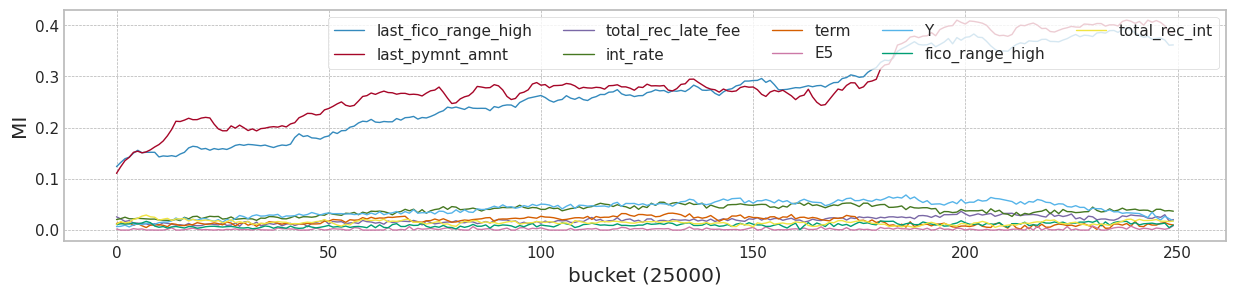

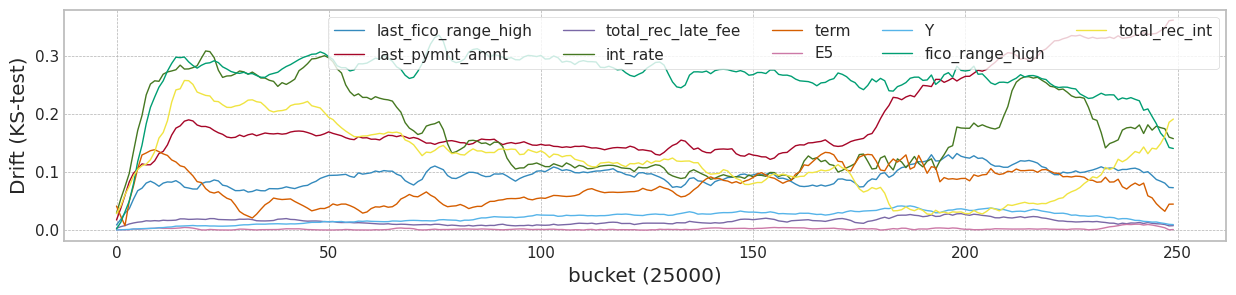

In [29]:
train_size = 25000
test_size = 5000

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [30]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.922353         0.023431            0.000000  0.425143   
1                    0.857647         0.007436            0.000000  0.352634   
2                    0.722353         0.271593            0.000000  0.479395   
3                    0.863529         0.015479            0.000000  0.551904   
4                    0.945882         0.019597            0.000000  0.334377   
...                       ...              ...                 ...       ...   
1279675              0.910588         0.000191            0.090128  0.235263   
1279676              0.851765         0.287652            0.000000  0.235263   
1279677              0.898824         0.238378            0.000000  0.133020   
1279678              0.916471         0.692330            0.000000 -0.005216   
1279679              0.875294         0.268684            0.000000  1.323422   

         term   E5    Y  fico_range_high  total_rec_int    b  
0         0.0  0.0  0.0         0.121212       0.113494    0  
1         0.0  0.0  0.0         0.606061       0.063276    0  
2         0.0  0.0  0.0         0.303030       0.015069    0  
3         0.0  0.0  0.0         0.000000       0.169520    0  
4         0.0  0.0  0.0         0.575758       0.164069    0  
...       ...  ...  ...              ...            ...  ...  
1279675   0.0  0.0  0.0         0.242424       0.020520  255  
1279676   0.0  0.0  0.0         0.454545       0.064211  255  
1279677   0.0  0.0  0.0         0.272727       0.016839  255  
1279678   0.0  0.0  0.0         0.696970       0.055566  255  
1279679   1.0  0.0  0.0         0.333333       0.120541  255  

[1279680 rows x 10 columns]

In [31]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) # np.max(X1['b'])+1)
result_df

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:09<00:00, 416.73it/s]


NameError: ignored

### Card data 실험

#### Dataset 준비

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download "ealtman2019/credit-card-transactions"

 95% 249M/263M [00:02<00:00, 105MB/s]
100% 263M/263M [00:02<00:00, 112MB/s]


In [ ]:
!unzip credit-card-transactions.zip

Archive:  credit-card-transactions.zip
  inflating: User0_credit_card_transactions.csv  
  inflating: credit_card_transactions-ibm_v2.csv  
  inflating: sd254_cards.csv         
  inflating: sd254_users.csv         


In [ ]:
df = pd.read_csv("credit_card_transactions-ibm_v2.csv")

In [ ]:
df['Year'].value_counts()

2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report
df['Is Fraud?']=df['Is Fraud?'].replace({'No':0,'Yes':1})
df1 = df[df['Is Fraud?']==1]
df2 = df[df['Is Fraud?']==0]
df3 = df2.sample(int(df2.shape[0]/30))
df4 = pd.concat([df1,df3])

print("Compression rate:",df4.shape[0] / df.shape[0] )

df = df4

Compression rate: 0.034512832709364456


In [ ]:
df['Errors?']=df['Errors?'].fillna('NAN')
df['Errors?']=df['Errors?'].apply(lambda value:value=='NAN')
df['Errors?'].value_counts()

df['Use Chip'].unique()
df['is online']=df['Use Chip'].apply(lambda value:value=='Online Transaction')

from sklearn.preprocessing import LabelEncoder
df['Use Chip']=df['Use Chip'].replace({'Swipe Transaction':0, 'Online Transaction':1, 'Chip Transaction':2})
df['Zip'] = df['Zip'].fillna(df['Zip'].mean())
df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
df.drop(['Time'], axis=1, inplace=True)
df['Merchant State']=df['Merchant State'].fillna('NAN')
df['Merchant City']=df['Merchant City'].fillna('NAN')
df['is vozmes']=df['Amount'].apply(lambda value: value<0)
df['abs_amount']=df['Amount'].apply(lambda value: abs(value))

#encoding categorial features
le=LabelEncoder()
df['Merchant State']=le.fit_transform(df['Merchant State'])
le=LabelEncoder()
df['Merchant City']=le.fit_transform(df['Merchant City'])
le=LabelEncoder()
df['Errors?']=le.fit_transform(df['Errors?'])
le=LabelEncoder()
df['is online']=le.fit_transform(df['is online'])
le=LabelEncoder()
df['is vozmes']=le.fit_transform(df['is vozmes'])

df = df.sort_values(['Year','Month','Day'])

df.Year.value_counts()

2016    60412
2015    60116
2018    59563
2019    59488
2017    57276
2013    57029
2014    56782
2012    54838
2010    53127
2011    52594
2009    46612
2008    44566
2007    37404
2006    31560
2005    25216
2004    20436
2003    15753
2002    11773
2020    11251
2001     8820
2000     6049
1999     3969
1998     2689
1997     1641
1996      968
1995      691
1994      511
1993      276
1992      185
1991       66
Name: Year, dtype: int64

In [ ]:
drop_columns = ['Is Fraud?','Zip','Year','Month','Day','Minutes','User','Errors?','Merchant Name','Merchant City','Merchant State']
X = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)].drop(drop_columns,axis=1)
y = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)]['Is Fraud?']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185358 entries, 17325692 to 342823
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Card        185358 non-null  int64  
 1   Amount      185358 non-null  float64
 2   Use Chip    185358 non-null  int64  
 3   MCC         185358 non-null  int64  
 4   is online   185358 non-null  int64  
 5   Hour        185358 non-null  int64  
 6   is vozmes   185358 non-null  int64  
 7   abs_amount  185358 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 12.7 MB


In [ ]:
np.sum(y[0:30000])

536

#### 실험

MI Analysis MI Max 0.04861, Min 0.00078, Mean 0.01996, Std 0.01460
Dataset structure X_train, (30000, 8) X_test, (30000, 8) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)
Search MI & Drift...for X_live_set (51, 30000, 8)


100%|██████████| 51/51 [00:54<00:00,  1.06s/it]


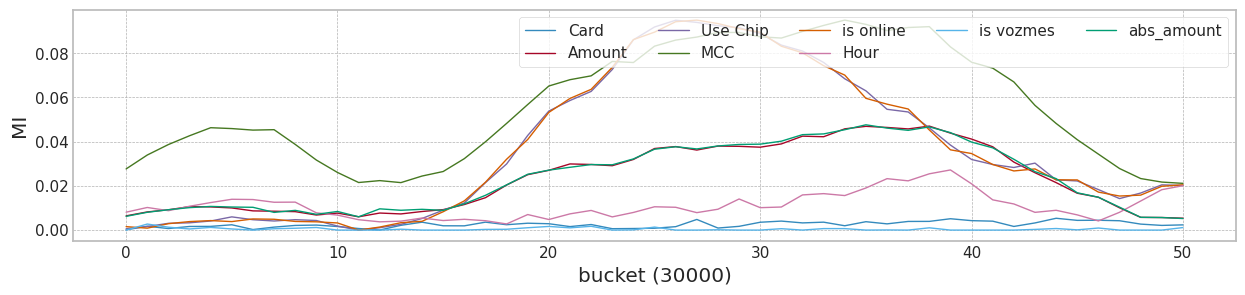

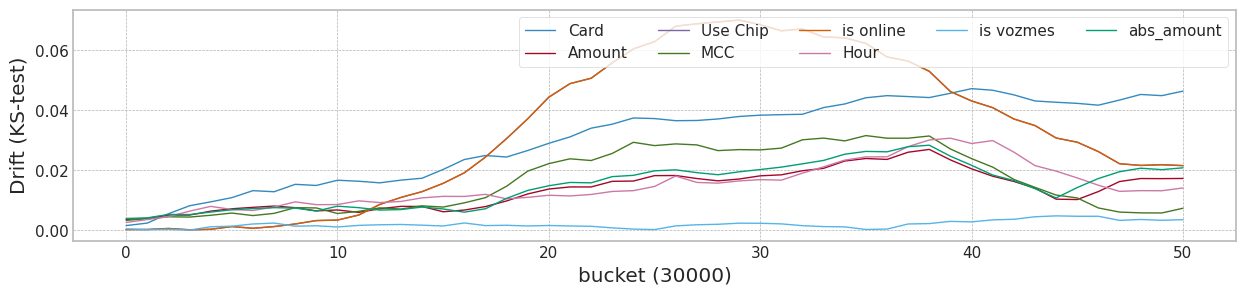

In [ ]:

train_size = 30000
test_size = 3000

X1,Y1 = check_mi_drift(X, y.values,train_size, test_size)

MI Analysis MI Max 0.02838, Min 0.00038, Mean 0.00683, Std 0.00866
cuda:0


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]

MSE: 0.10
RMSE: 0.32


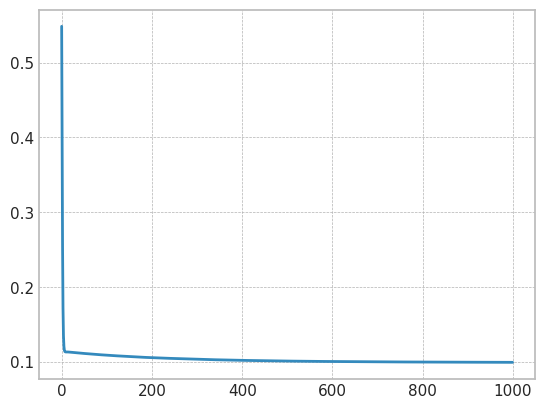

F1 Score:0.00000
Dataset structure X_train, torch.Size([30000, 8]) X_test, torch.Size([30000, 8]) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)


100%|██████████| 51/51 [00:00<00:00, 96.38it/s]


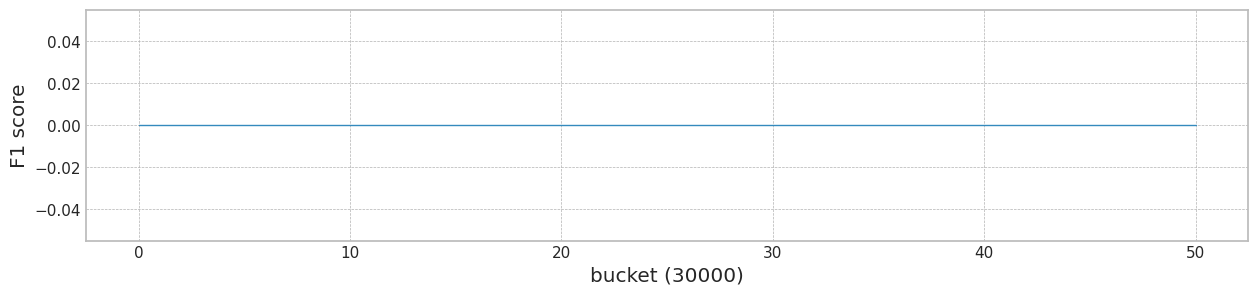

   test_f1  init_f1  mean_f1  last_f1   SUM(MI)
0      0.0      0.0      0.0      0.0  0.054619


In [ ]:
model,df = train_classificaion_model(X1,Y1,train_size, test_size)